# Enzyme Classification Using Protein Structure Data

## Introduction

This project utilizes the **RCSB_PDB Human Macromolecular Structure Dataset** from **Kaggle.com**. The dataset contains **11,832 protein structures** obtained from the **RCSB Protein Data Bank (PDB)** between **2015 and 2023**. It includes **51 features** spanning taxonomic data, sequence characteristics, crystallization conditions, and more — offering rich potential for machine learning tasks, such as **enzyme classification**.

### Problem Statement

The goal of this project is to build a model that predicts the **enzyme classification** of a given protein structure based on selected features. Understanding an enzyme’s class can reveal its biological function, potential behavior in the body, and impact on health, which is critical in **drug discovery** and **healthcare applications**.

### Features Used

Out of the 51 features available, **17 were selected** based on their biological relevance and potential impact on enzyme classification:

- **Structure and Sequence**:
  - Number of amino acids (residues)
  - Number of chains
  - Amino acid sequence
  - Number of helices, sheets, and coils (secondary structure)

- **Assembly Information**:
  - Oligomeric state
  - Stoichiometry

- **Molecular Properties**:
  - Molecular weight
  - Macromolecule type

- **Crystallization Conditions**:
  - pH
  - Temperature
  - Percent solvent content
  - Crystallization method

These features were chosen because enzymes of the same class often exhibit **similar structural motifs and environmental conditions**. By learning these patterns, a model can **infer the class of an enzyme** with high accuracy.

The **target variable** is the **enzyme classification**, which is represented as a categorical numerical code in the dataset.

## Data Pre-processing

In this section, we:
- Load the dataset and examine its structure.
- Clean the data by handling missing values.
- Encode categorical variables.
- Extract the target variable and reduce the enzyme classification to its first digit.
- Normalize numerical features using standard scaling.
- Split the data into training and testing sets for model evaluation.


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.utils.multiclass import unique_labels
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [24]:
path = "RCSB_PDB_Macromolecular_Structure_Dataset_with_Structural_Features.csv"
Dataset = pd.read_csv(path)

In [25]:
num_columns = Dataset.shape[1]
print("Number of columns:",num_columns)

Number of columns: 51


In [30]:
df = pd.DataFrame()
columns = ['PDB ID', 'Percent Solvent Content', 'Crystallization Method', 'pH','Temp (K)', 'Molecular Weight per Deposited Model', 'Sequence', 'Entity Macromolecule Type', 'Molecular Weight (Entity)', 'EC Number', 'Oligomeric State', 'Stoichiometry', 'Number of Residues', 'Number of Chains', 'Helix', 'Sheet', 'Coil']
selected_columns = Dataset[columns]

# Adding the selected columns to the empty DataFrame
df = Dataset[columns].copy()

print(df.head)

<bound method NDFrame.head of       PDB ID  Percent Solvent Content         Crystallization Method   pH  \
0       6SJZ                    44.16  VAPOR DIFFUSION, HANGING DROP  5.5   
1       5C37                    45.64  VAPOR DIFFUSION, HANGING DROP  8.0   
2       6NNA                    45.48  VAPOR DIFFUSION, HANGING DROP  7.6   
3       7M4C                    56.57  VAPOR DIFFUSION, SITTING DROP  7.5   
4       7M4E                    56.66  VAPOR DIFFUSION, SITTING DROP  7.5   
...      ...                      ...                            ...  ...   
11827   6T3M                    52.68  VAPOR DIFFUSION, HANGING DROP  7.5   
11828   6WLX                    42.21  VAPOR DIFFUSION, HANGING DROP  7.5   
11829   8D6J                    42.67  VAPOR DIFFUSION, HANGING DROP  NaN   
11830   7C6B                    52.74  VAPOR DIFFUSION, SITTING DROP  8.0   
11831   7D7U                    52.82  VAPOR DIFFUSION, SITTING DROP  8.0   

       Temp (K)  Molecular Weight per Deposit

In [31]:
numeric_cols = ['Percent Solvent Content', 'pH', 'Temp (K)', 
                'Molecular Weight per Deposited Model', 'Molecular Weight (Entity)',
                'Number of Residues', 'Number of Chains', 'Helix', 'Sheet', 'Coil']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df['EC Class'] = df['EC Number'].astype(str).str[0]

plot_cols = ['Percent Solvent Content', 'pH', 'Temp (K)', 
             'Number of Residues', 'Number of Chains', 'Helix', 'Sheet', 'Coil']
print(df.isnull().sum())


PDB ID                                     0
Percent Solvent Content                  131
Crystallization Method                   297
pH                                      4049
Temp (K)                                 316
Molecular Weight per Deposited Model       0
Sequence                                   0
Entity Macromolecule Type                  0
Molecular Weight (Entity)                  0
EC Number                                674
Oligomeric State                           0
Stoichiometry                              0
Number of Residues                       392
Number of Chains                         392
Helix                                    392
Sheet                                    392
Coil                                     392
EC Class                                   0
dtype: int64


In [32]:
print("Original shape:", df.shape)
df = df.dropna(subset=columns)
print("After dropping NaNs in subset of columns:", df.shape)


Original shape: (11832, 18)
After dropping NaNs in subset of columns: (6876, 18)


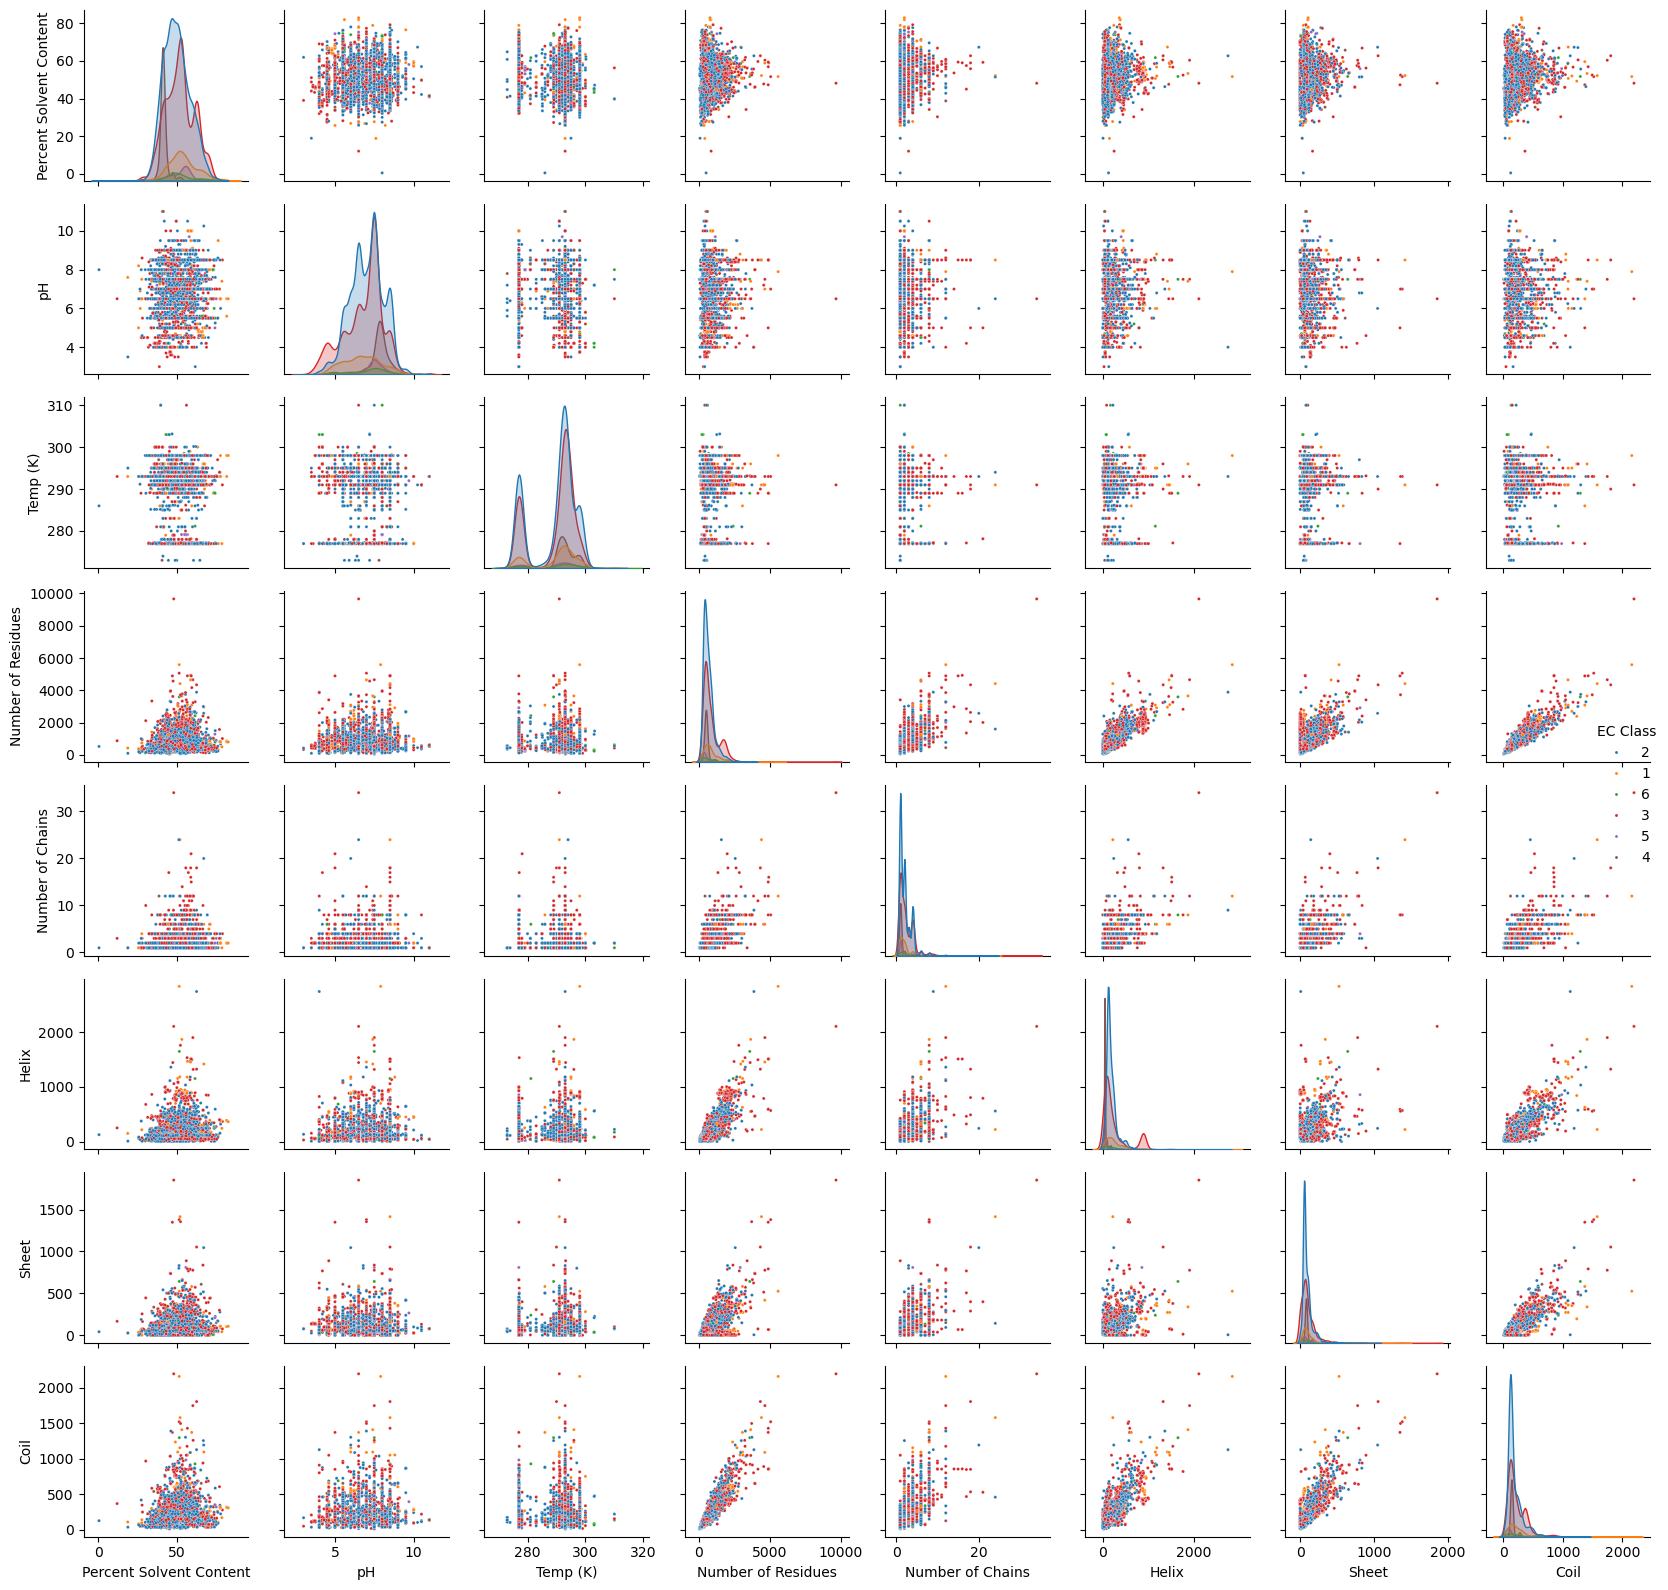

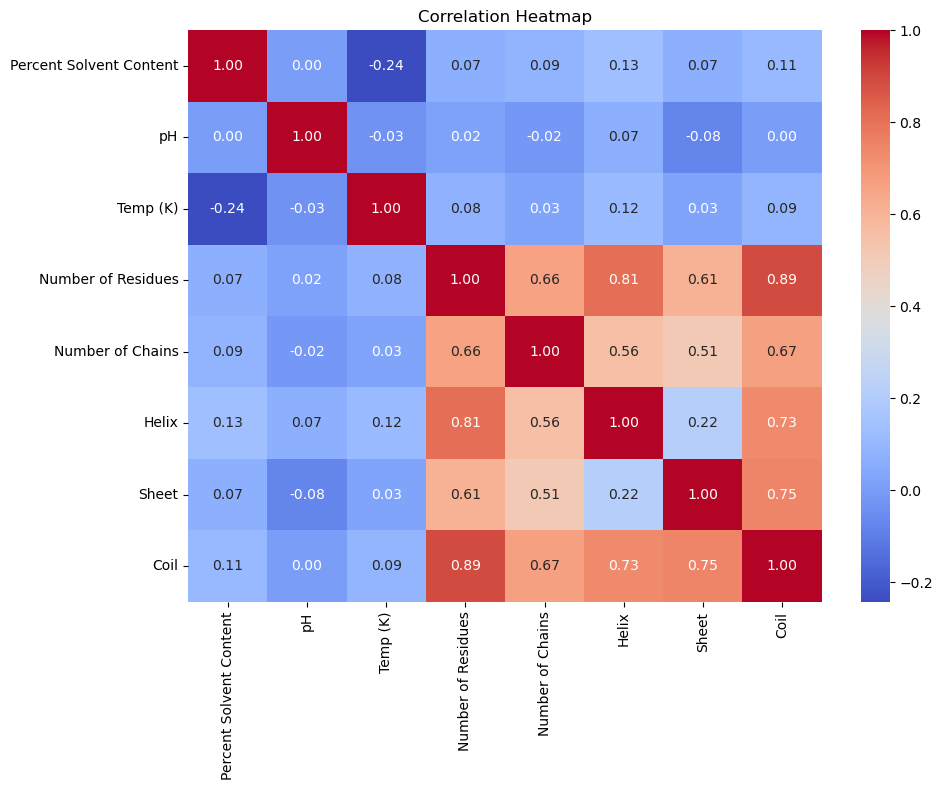

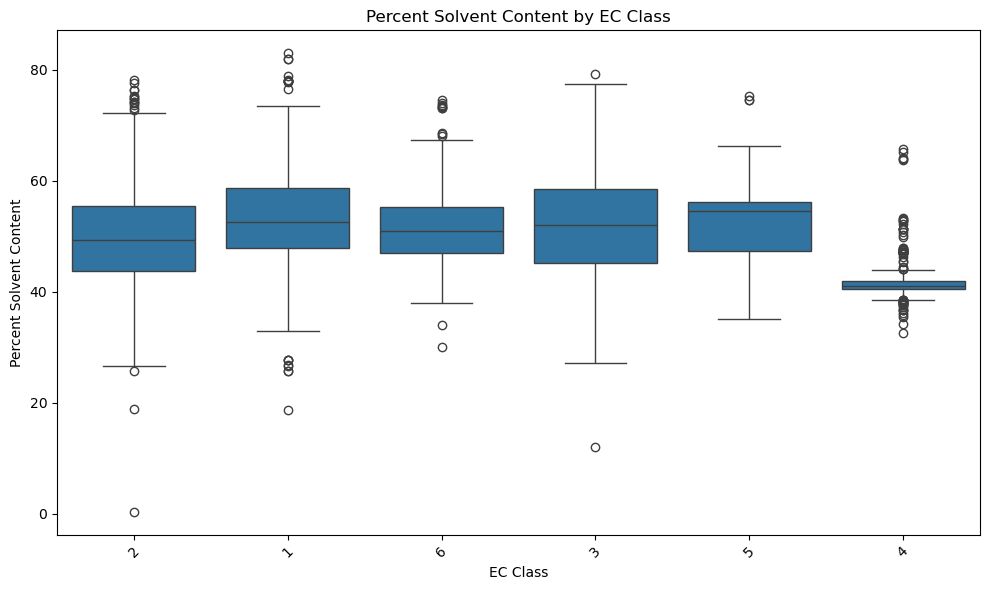

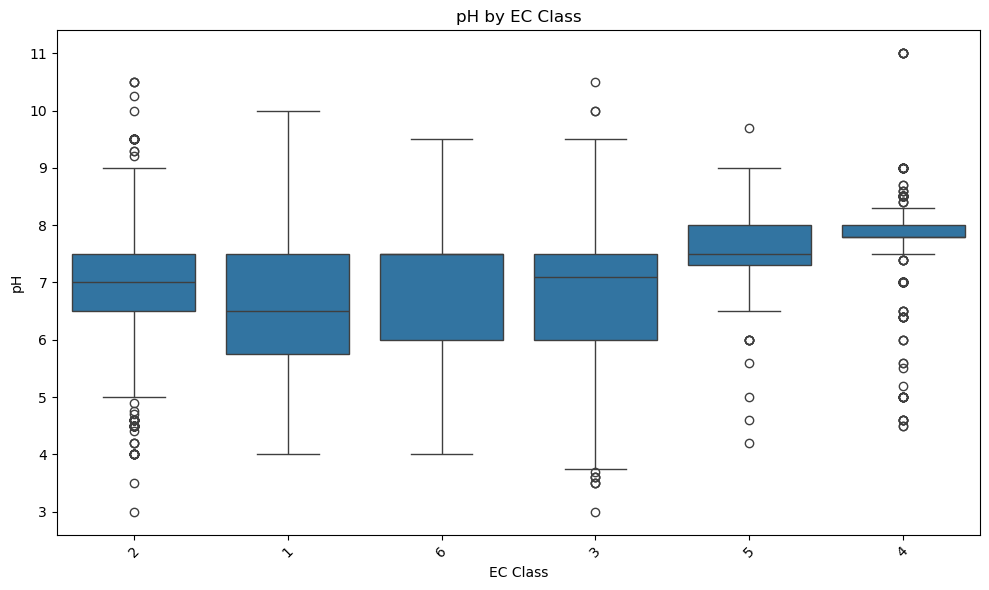

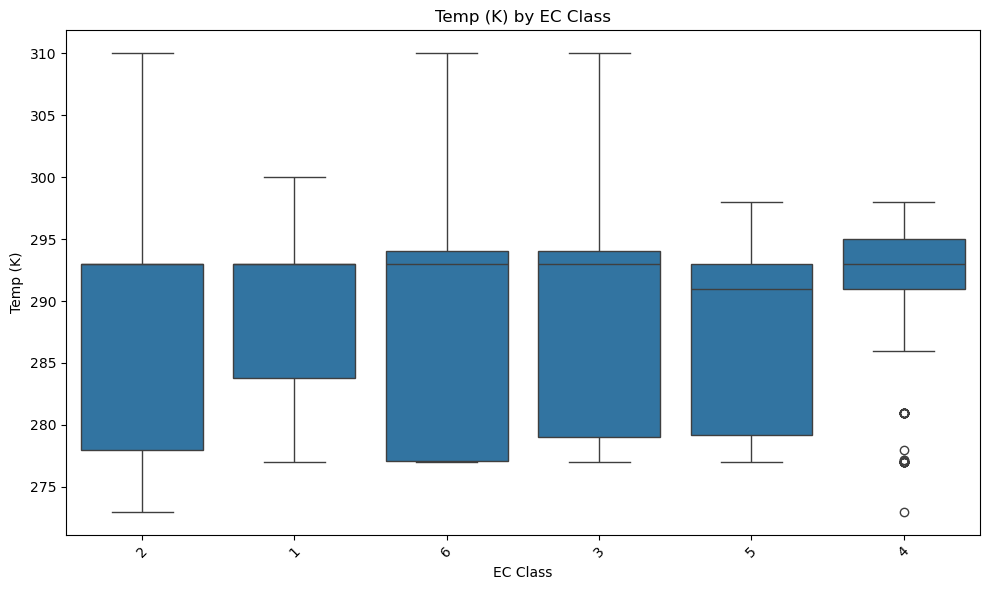

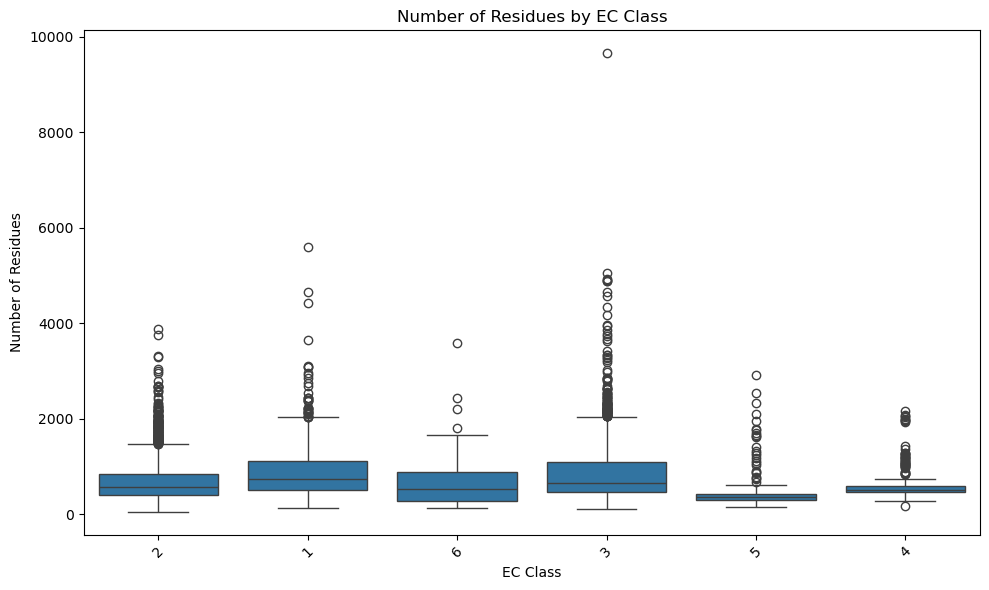

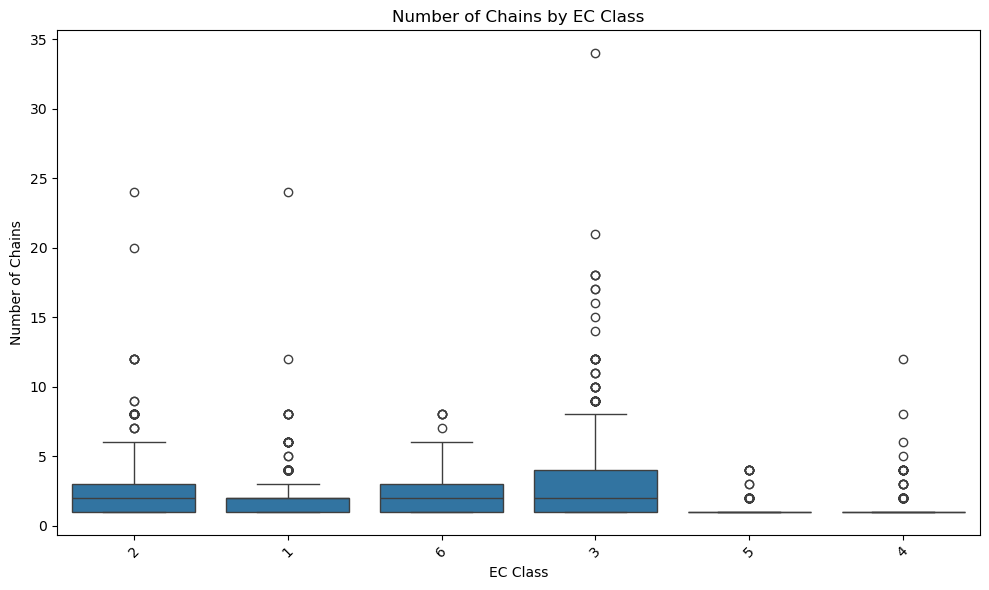

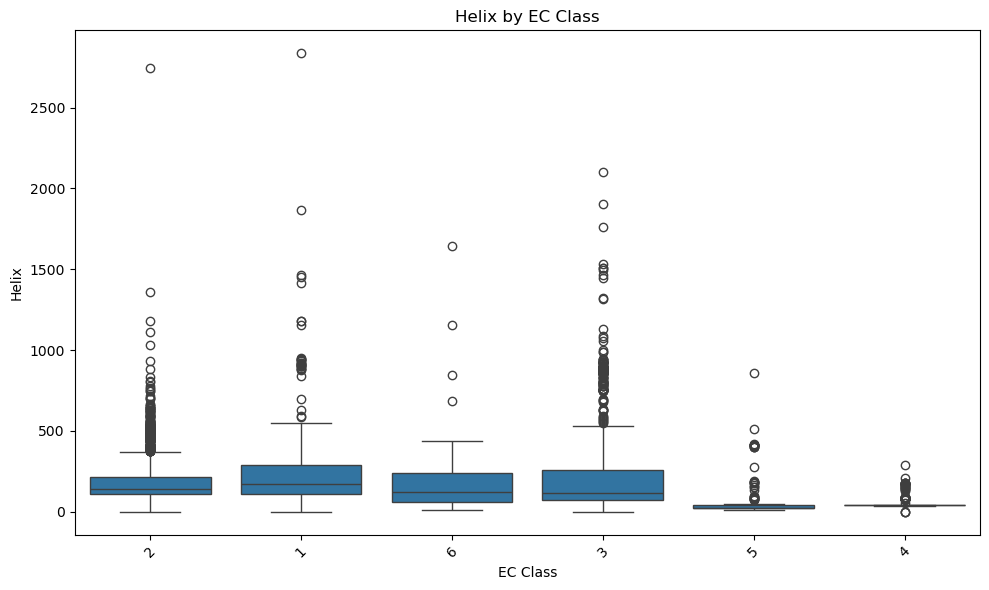

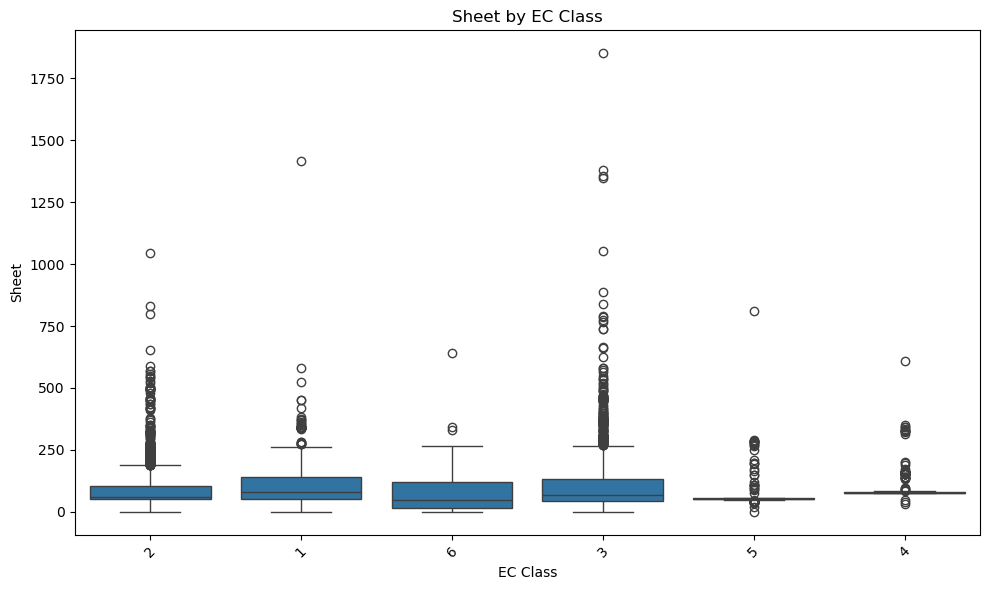

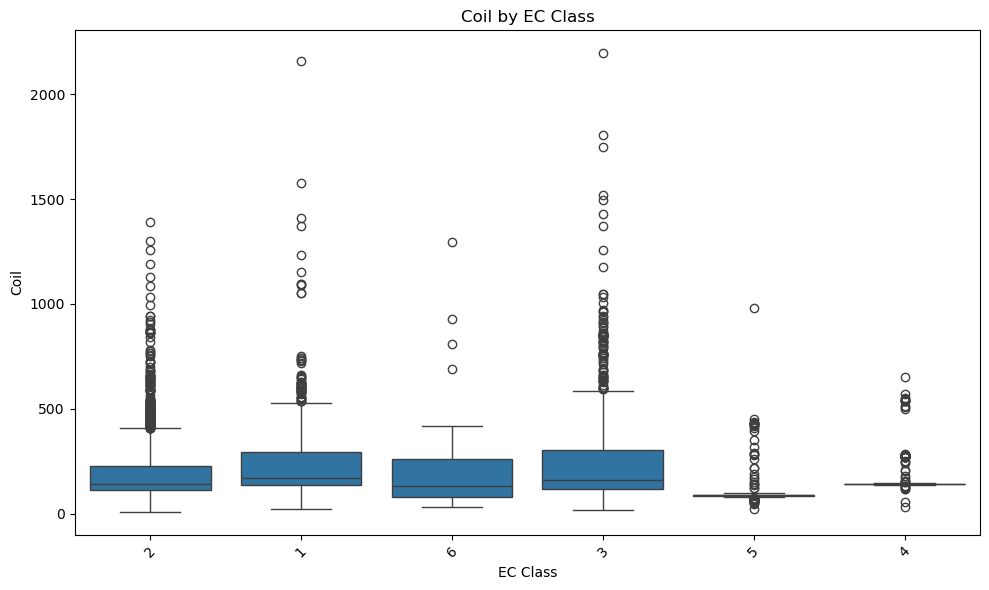

In [7]:
sns.pairplot(data=df, 
             vars=plot_cols,
             hue='EC Class',
             height=2,
             plot_kws={'s': 5})
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df[plot_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

for col in plot_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='EC Class', y=col, data=df)
    plt.title(f"{col} by EC Class")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
print(df['EC Class'].unique())

['2' '1' '6' '3' '5' '4']


In [9]:
print(df['EC Number'].unique())

['2.3.1.97' '2.3.1.85' '2.7.7.7' '1' '6.3.5.5' '1.1.1' '2.7.7' '3.2.1.14'
 '6.3.2' '5.2.1.8' '1.3.1' '4.2.1.1' '2.7.1.67' '3.1.4' '2.5.1.151'
 '3.2.2' '6.3.4.13' '6.3.5.4' '3.4.22' '2.3.2.5' '3.1.3' '1.17.4.4'
 '3.1.3.16' '1.7' '3.6.5.2' '6.3.2.19' '3.1.3.48' '1.14.14.1' '3.1'
 '2.7.11.1' '2.3.2.26' '2.6.1.13' '1.14.11' '3.4.19.12' '2.4.2' '2.1'
 '1.14.11.4' '2.7.7.49' '3.1.3.3' '3.6' '1.14.11.27' '2.7.10.2' '1.5.1.3'
 '1.6.2.2' '2.7.11.30' '1.14.11.73' '4.6.1.18' '4.2.1.2' '5.3.4.1'
 '3.1.21' '2.7.7.14' '3.6.4' '2.1.1' '3.2.2.6' '2.7.11.17' '2.3.2.27'
 '6.5.1.1' '4.2.1.107' '1.11.1.12' '3.4.22.29' '3.4.24' '2.7.1.107'
 '2.7.11.24' '2.4.99.1' '1.5.1.30' '1.14.14.19' '3.4.11.14' '3.1.1.98'
 '5.99.1.2' '3.1.2' '1.14.11.29' '2.4.1' '3.6.4.12' '6.1.1.3' '3.1.27'
 '3.6.1' '6.1.1.10' '2.7.1.105' '4.3.2.7' '2.3.1' '1.14.11.16'
 '1.14.14.14' '3.6.4.10' '3.2.1.17' '3.2.1.8' '3.4.22.38' '1.1.1.300'
 '4.1.1.84' '6.5.1.8' '3.4.17.17' '1.14.14.154' '6.1.1.19' '6.1.1.18'
 '3.6.1.55' '1.1.1.21' '3.2.

In [10]:
unique_ec_count = df['EC Number'].nunique()
print(f"Total number of unique EC Numbers: {unique_ec_count}")

Total number of unique EC Numbers: 372


# Model Setup

In this section, we set up one or more machine learning models to perform enzyme classification. 
Key objectives:
- Train the model using the training data.
- Evaluate initial performance using accuracy and classification reports.

## For EC Class

In [11]:
X = df[['Percent Solvent Content', 'pH', 'Temp (K)', 
        'Molecular Weight per Deposited Model', 'Molecular Weight (Entity)',
        'Number of Residues', 'Number of Chains', 'Helix', 'Sheet', 'Coil']]

y_class = df['EC Class']

print(f"Number of unique EC Class values: {y_class.nunique()}")

le_class = LabelEncoder()
y_class_encoded = le_class.fit_transform(y_class)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_class_encoded, test_size=0.2, random_state=42, stratify=y_class_encoded)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Number of unique EC Class values: 6


In [13]:
model_params = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'max_iter': [1000, 2000],
            'solver': ['lbfgs', 'saga']
        }
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.1, 0.01],
            'kernel': ['rbf', 'linear']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='mlogloss', random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.3]
        }
    }
}

# Dictionary to store results
results = {}
tuned_results = {}

In [14]:
# Initial model evaluation without tuning
print("Evaluating base models...")
for name, model_info in model_params.items():
    model = model_info['model']
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{name} (Base) - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    results[name] = {
        'accuracy': accuracy,
        'f1_score': f1,
        'model': model
    }

Evaluating base models...
Training Logistic Regression...
Logistic Regression (Base) - Accuracy: 0.5589, F1 Score: 0.5113
Training SVM...
SVM (Base) - Accuracy: 0.7260, F1 Score: 0.7081
Training Random Forest...
Random Forest (Base) - Accuracy: 0.9048, F1 Score: 0.9046
Training XGBoost...
XGBoost (Base) - Accuracy: 0.9026, F1 Score: 0.9022



Training and tuning Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

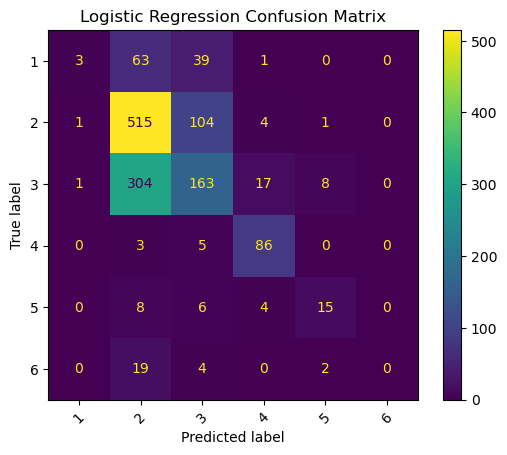


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           1       0.60      0.03      0.05       106
           2       0.56      0.82      0.67       625
           3       0.51      0.33      0.40       493
           4       0.77      0.91      0.83        94
           5       0.58      0.45      0.51        33
           6       0.00      0.00      0.00        25

    accuracy                           0.57      1376
   macro avg       0.50      0.43      0.41      1376
weighted avg       0.55      0.57      0.52      1376


Training and tuning SVM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


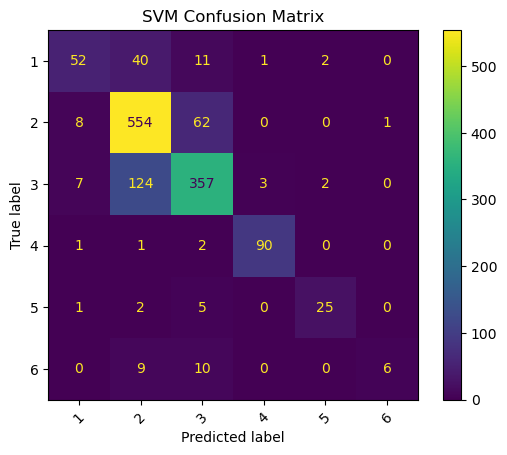


Classification Report for SVM:

              precision    recall  f1-score   support

           1       0.75      0.49      0.59       106
           2       0.76      0.89      0.82       625
           3       0.80      0.72      0.76       493
           4       0.96      0.96      0.96        94
           5       0.86      0.76      0.81        33
           6       0.86      0.24      0.38        25

    accuracy                           0.79      1376
   macro avg       0.83      0.68      0.72      1376
weighted avg       0.79      0.79      0.78      1376


Training and tuning Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


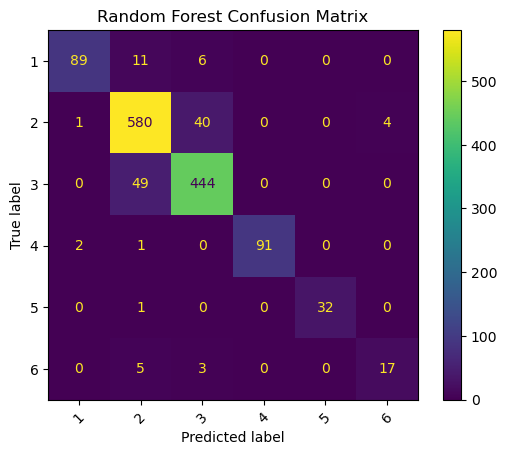


Classification Report for Random Forest:

              precision    recall  f1-score   support

           1       0.97      0.84      0.90       106
           2       0.90      0.93      0.91       625
           3       0.90      0.90      0.90       493
           4       1.00      0.97      0.98        94
           5       1.00      0.97      0.98        33
           6       0.81      0.68      0.74        25

    accuracy                           0.91      1376
   macro avg       0.93      0.88      0.90      1376
weighted avg       0.91      0.91      0.91      1376


Training and tuning XGBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


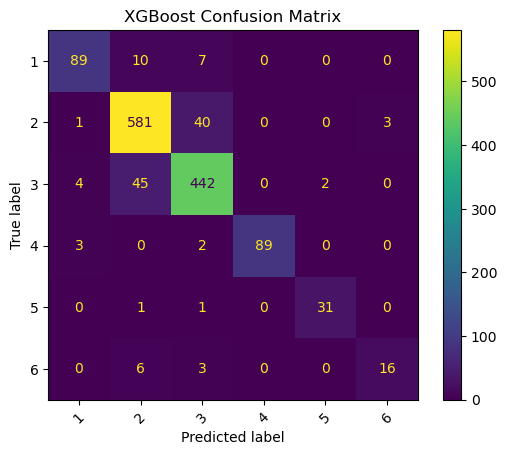


Classification Report for XGBoost:

              precision    recall  f1-score   support

           1       0.92      0.84      0.88       106
           2       0.90      0.93      0.92       625
           3       0.89      0.90      0.89       493
           4       1.00      0.95      0.97        94
           5       0.94      0.94      0.94        33
           6       0.84      0.64      0.73        25

    accuracy                           0.91      1376
   macro avg       0.92      0.87      0.89      1376
weighted avg       0.91      0.91      0.91      1376



In [15]:
# Confusion Matrix and Classification Report

for model_name, mp in model_params.items():
    print(f"\nTraining and tuning {model_name}...")
    
    # Set up GridSearchCV
    grid = GridSearchCV(
        estimator=mp['model'],
        param_grid=mp['params'],
        cv=5,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    
    # Fit model
    grid.fit(X_train_scaled, y_train)
    best_model = grid.best_estimator_
    
    # Save best params and best CV score
    tuned_results[model_name] = {
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
        'model': best_model
    }
    
    # Predict on the test set
    y_pred = best_model.predict(X_test_scaled)
    
    # Save test accuracy
    results[model_name] = best_model.score(X_test_scaled, y_test)
    
    # Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_class.classes_)
    disp.plot(xticks_rotation=45)
    plt.title(f'{model_name} Confusion Matrix')
    plt.grid(False)
    plt.show()
    
    # Classification Report
    print(f"\nClassification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred, target_names=le_class.classes_))


## For EC Number Full

- Using full EC Numbers as target variable
- Removing any EC numbers that have only 1 sample

In [16]:
# Feature selection
X_full = df[['Percent Solvent Content', 'pH', 'Temp (K)', 
        'Molecular Weight per Deposited Model', 'Molecular Weight (Entity)',
        'Number of Residues', 'Number of Chains', 'Helix', 'Sheet', 'Coil']]

# Use full EC Number as target
y_full_original = df['EC Number']
print(f"Number of unique EC Number values: {y_full_original.nunique()}")

# Filter out rare EC numbers (keep only those with at least 2 examples)
value_counts_full = y_full_original.value_counts()
valid_ec_numbers = value_counts_full[value_counts_full >= 2].index
mask_full = y_full_original.isin(valid_ec_numbers)

X_filtered_full = X_full[mask_full]
y_filtered_full = y_full_original[mask_full]

print(f"Original dataset size: {len(X_full)}")
print(f"Filtered dataset size: {len(X_filtered_full)}")
print(f"Removed {len(X_full) - len(X_filtered_full)} examples ({(len(X_full) - len(X_filtered_full))/len(X_full)*100:.2f}%) with rare EC numbers")
print(f"Remaining unique EC Number values: {y_filtered_full.nunique()}")

# Encode the filtered target variable
le_full_ec = LabelEncoder()
y_encoded_full = le_full_ec.fit_transform(y_filtered_full)

# Now we can use stratification since all classes have at least 2 examples
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_filtered_full, y_encoded_full, test_size=0.2, random_state=42, stratify=y_encoded_full)
    
print(f"Training set shape: {X_train_full.shape}, Test set shape: {X_test_full.shape}")

# Scale features
scaler_full = StandardScaler()
X_train_scaled_full = scaler_full.fit_transform(X_train_full)
X_test_scaled_full = scaler_full.transform(X_test_full)

Number of unique EC Number values: 372
Original dataset size: 6876
Filtered dataset size: 6779
Removed 97 examples (1.41%) with rare EC numbers
Remaining unique EC Number values: 275
Training set shape: (5423, 10), Test set shape: (1356, 10)


In [19]:
# Define models with hyperparameter grids for Full EC Number
model_params_full = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'max_iter': [1000, 2000],
            'solver': ['lbfgs', 'saga']
        }
    },
    'SVM': {
        'model': SVC(probability=True, random_state=42),
        'params': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.1, 0.01],
            'kernel': ['rbf', 'linear']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='mlogloss', random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 6, 9],
            'learning_rate': [0.01, 0.1, 0.3]
        }
    }
}

# Dictionary to store results for Full EC Number
results_full = {}
tuned_results_full = {}

In [20]:
# Initial model evaluation without tuning
print("Evaluating base models for full EC Number...")
for name, model_info in model_params_full.items():
    model = model_info['model']
    print(f"Training {name}...")
    model.fit(X_train_scaled_full, y_train_full)
    y_pred_full = model.predict(X_test_scaled_full)
    
    accuracy_full = accuracy_score(y_test_full, y_pred_full)
    f1_full = f1_score(y_test_full, y_pred_full, average='weighted')
    
    print(f"{name} (Base) - Accuracy: {accuracy_full:.4f}, F1 Score: {f1_full:.4f}")
    
    results_full[name] = {
        'accuracy': accuracy_full,
        'f1_score': f1_full,
        'model': model
    }

Evaluating base models for full EC Number...
Training Logistic Regression...
Logistic Regression (Base) - Accuracy: 0.4425, F1 Score: 0.3748
Training SVM...
SVM (Base) - Accuracy: 0.5147, F1 Score: 0.4617
Training Random Forest...
Random Forest (Base) - Accuracy: 0.8503, F1 Score: 0.8332
Training XGBoost...
XGBoost (Base) - Accuracy: 0.8178, F1 Score: 0.8033



Training and tuning Logistic Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

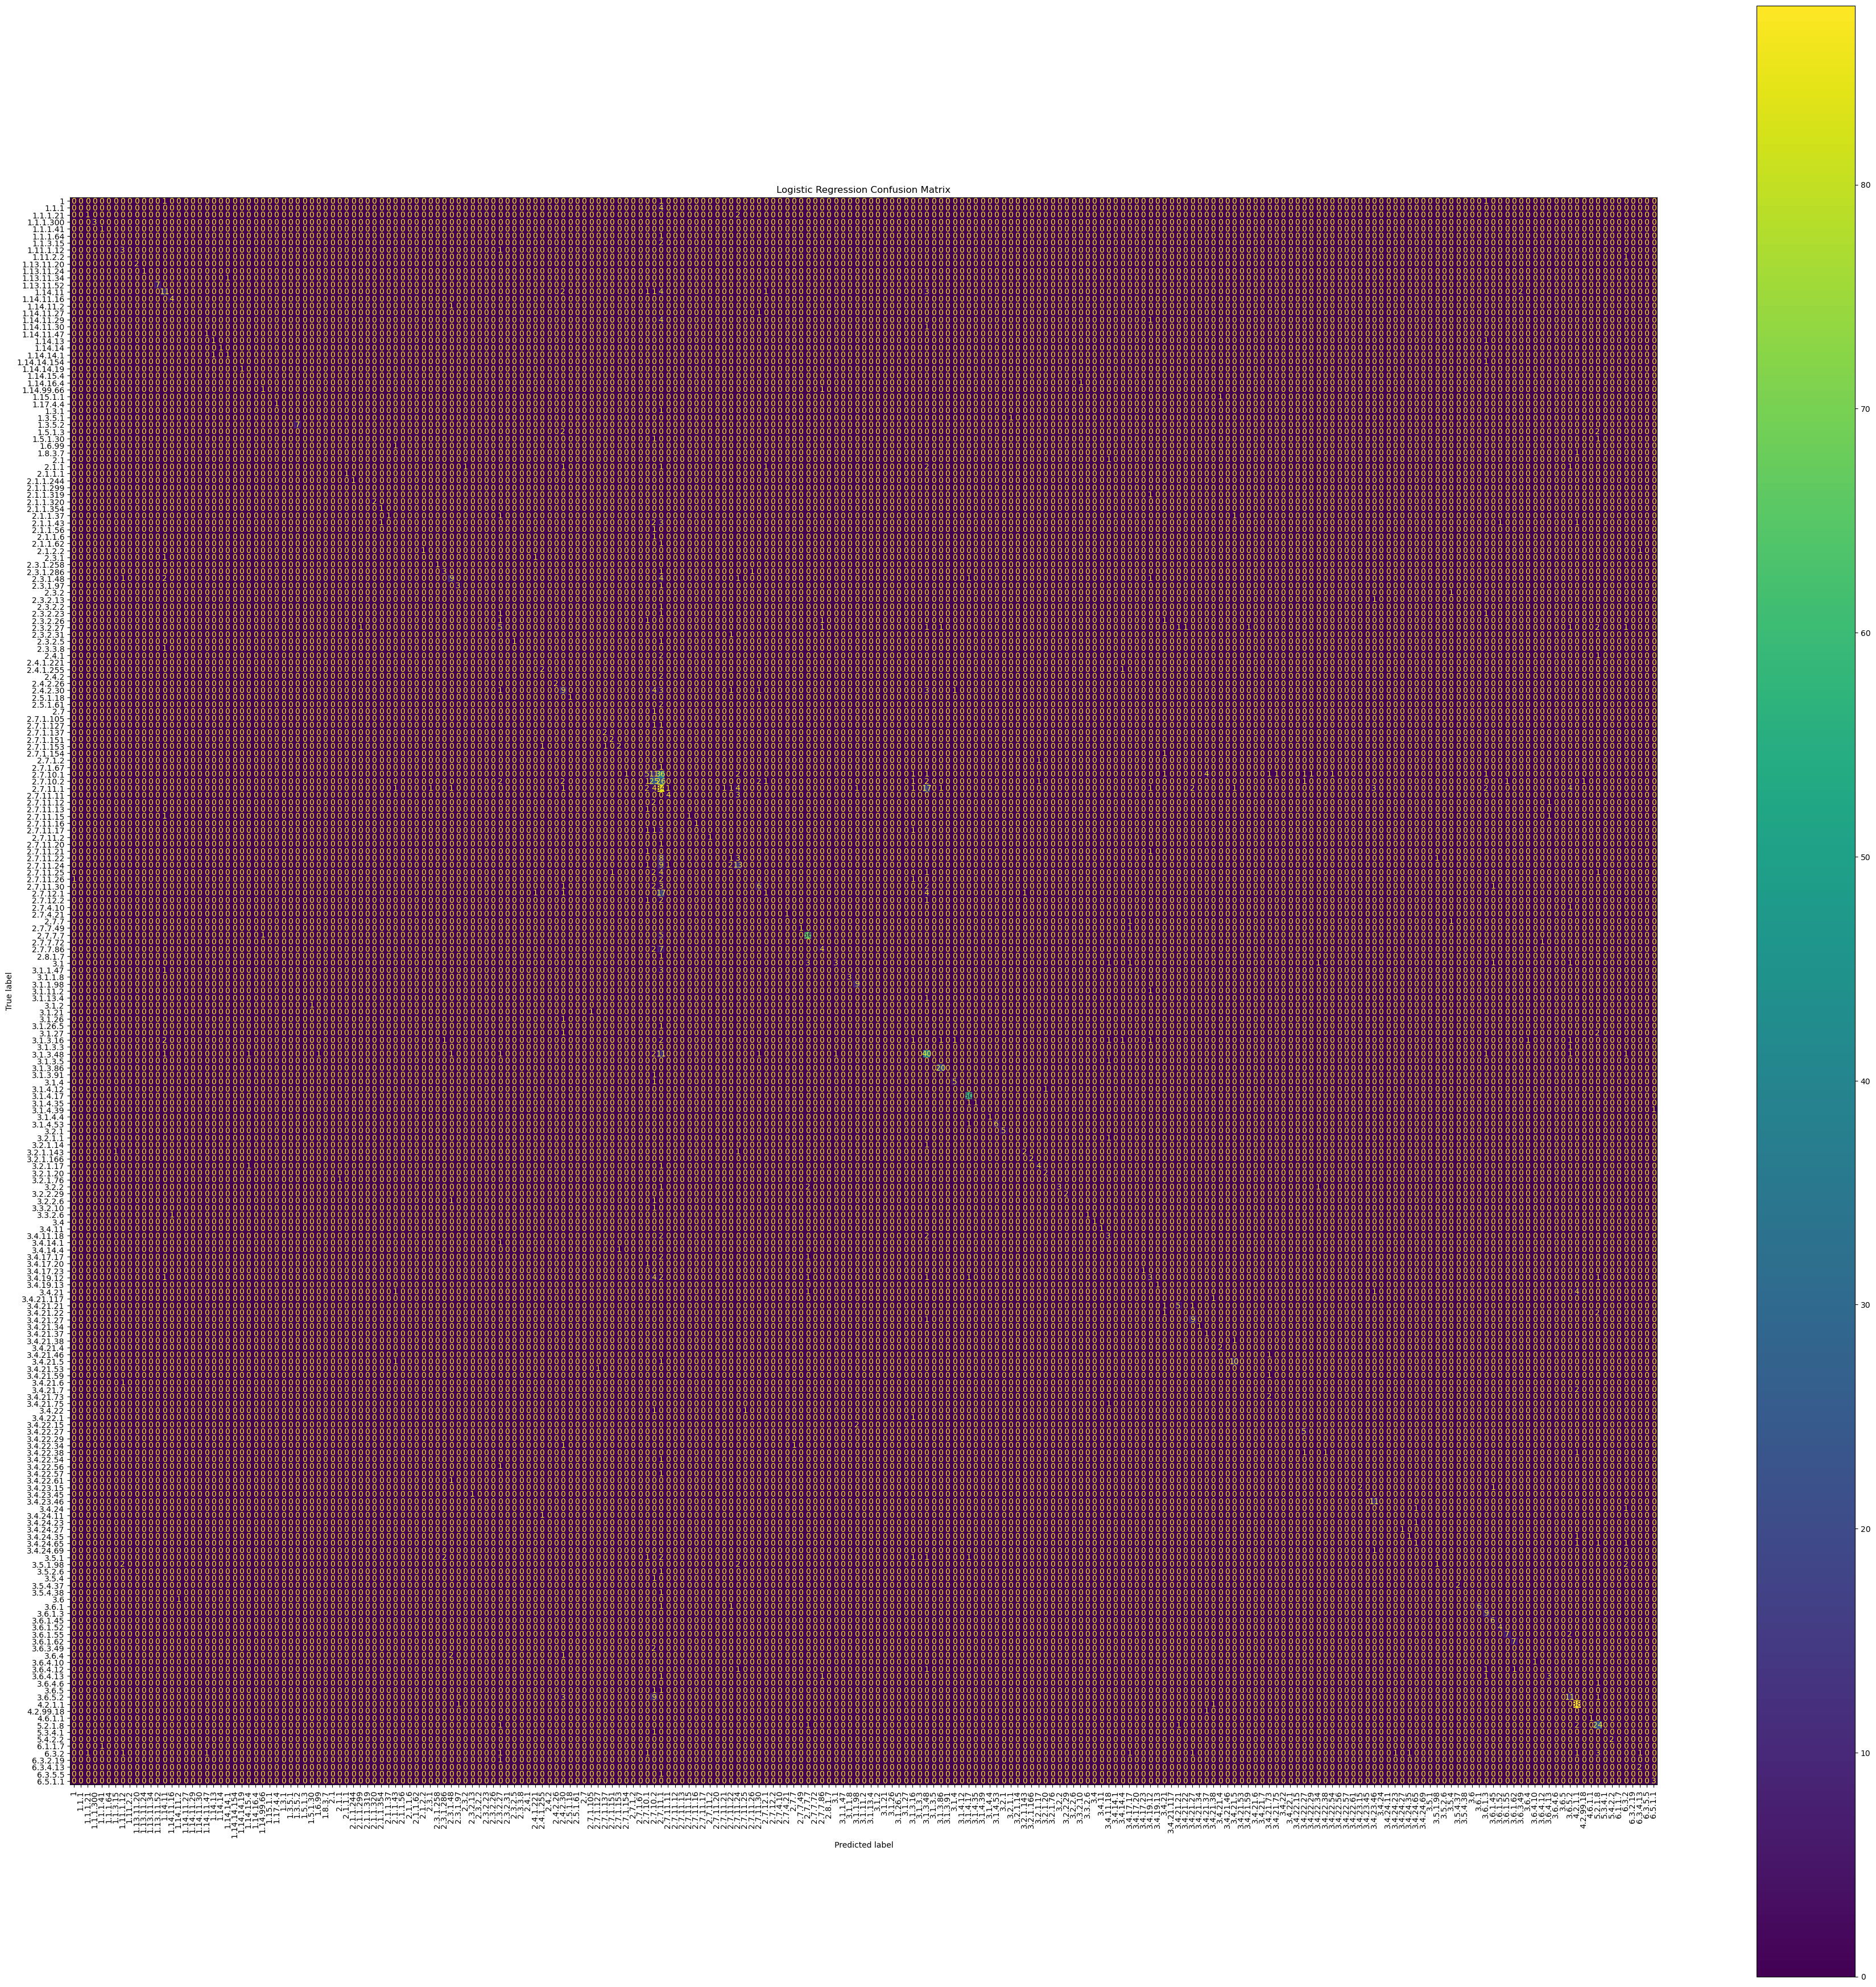


Classification Report for Logistic Regression:



precision  recall  f1-score  support
1                 0.000   0.000     0.000     3.00
1.1.1             0.000   0.000     0.000     4.00
1.1.1.21          0.500   0.333     0.400     3.00
1.1.1.300         1.000   1.000     1.000     3.00
1.1.1.41          0.500   1.000     0.667     1.00
...                 ...     ...       ...      ...
6.3.5.5           0.000   0.000     0.000     1.00
6.5.1.1           0.750   1.000     0.857     3.00
accuracy          0.530   0.530     0.530     0.53
macro avg         0.348   0.354     0.338  1356.00
weighted avg      0.483   0.530     0.487  1356.00

[230 rows x 4 columns]


Training and tuning SVM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


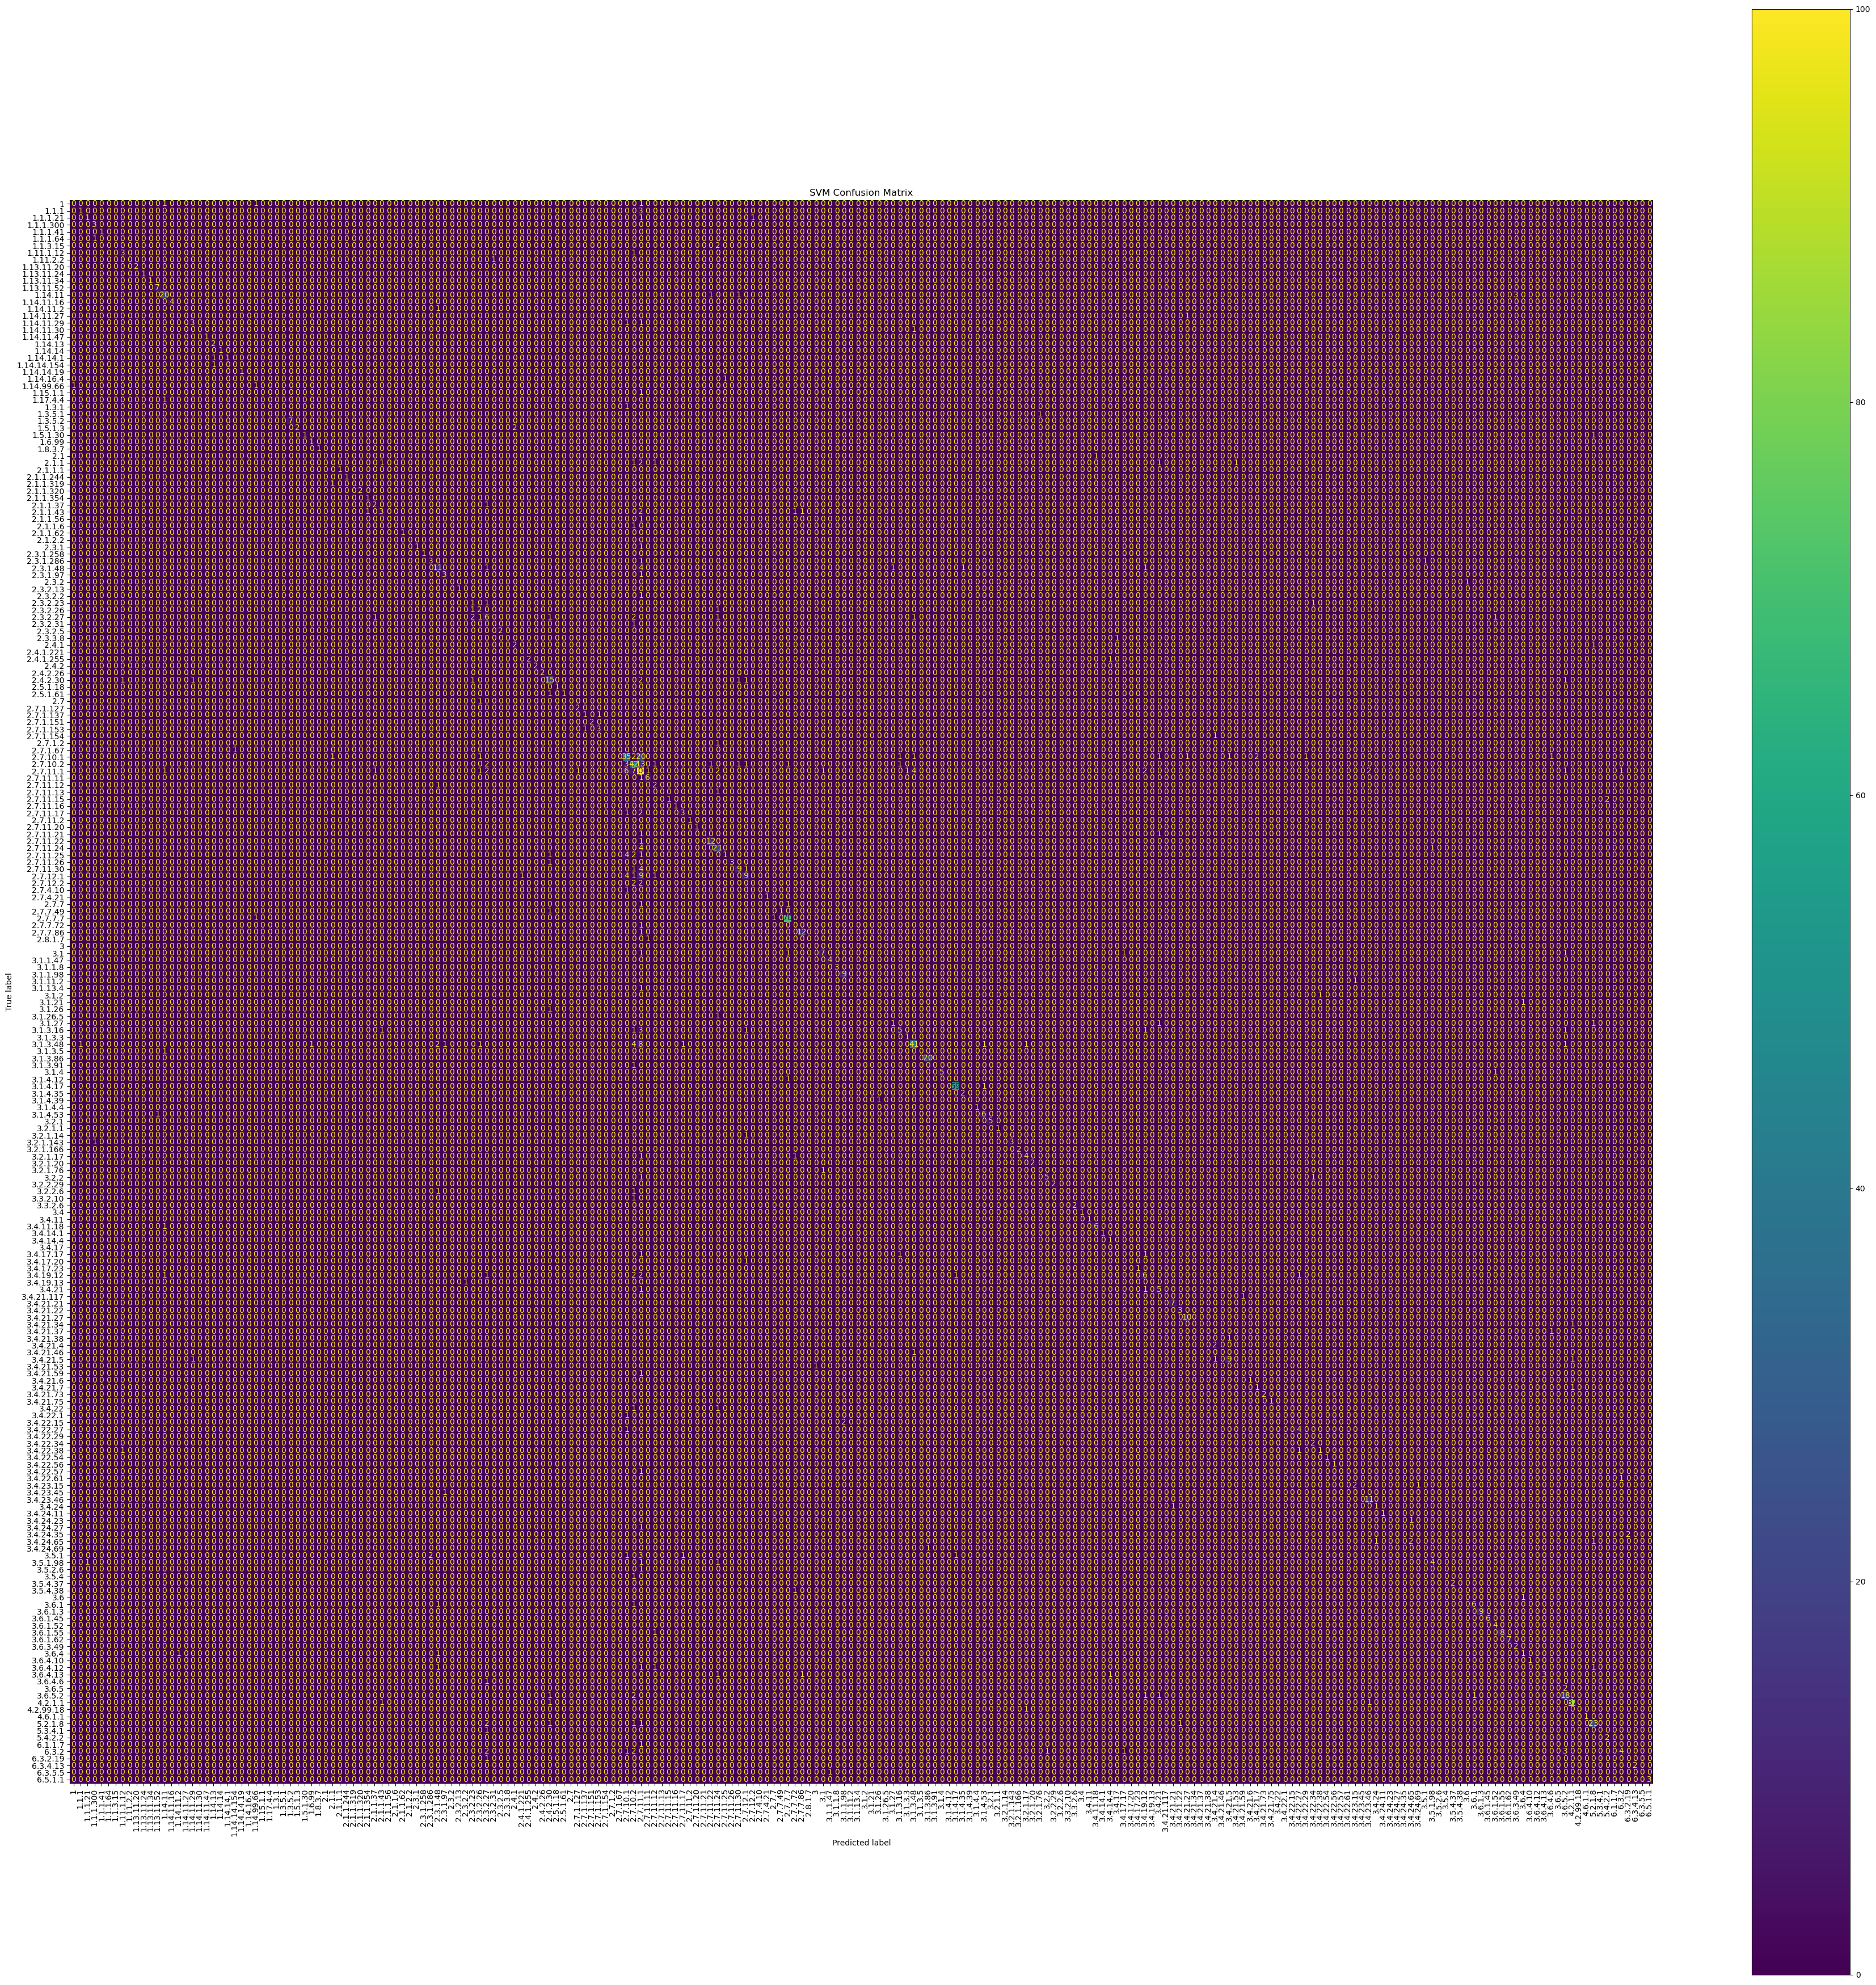


Classification Report for SVM:



precision  recall  f1-score   support
1                 0.000   0.000     0.000     3.000
1.1.1             0.500   0.250     0.333     4.000
1.1.1.21          0.500   0.333     0.400     3.000
1.1.1.300         0.600   1.000     0.750     3.000
1.1.1.41          1.000   1.000     1.000     1.000
...                 ...     ...       ...       ...
6.3.5.5           0.000   0.000     0.000     1.000
6.5.1.1           1.000   1.000     1.000     3.000
accuracy          0.692   0.692     0.692     0.692
macro avg         0.494   0.505     0.487  1356.000
weighted avg      0.674   0.692     0.672  1356.000

[229 rows x 4 columns]


Training and tuning Random Forest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits


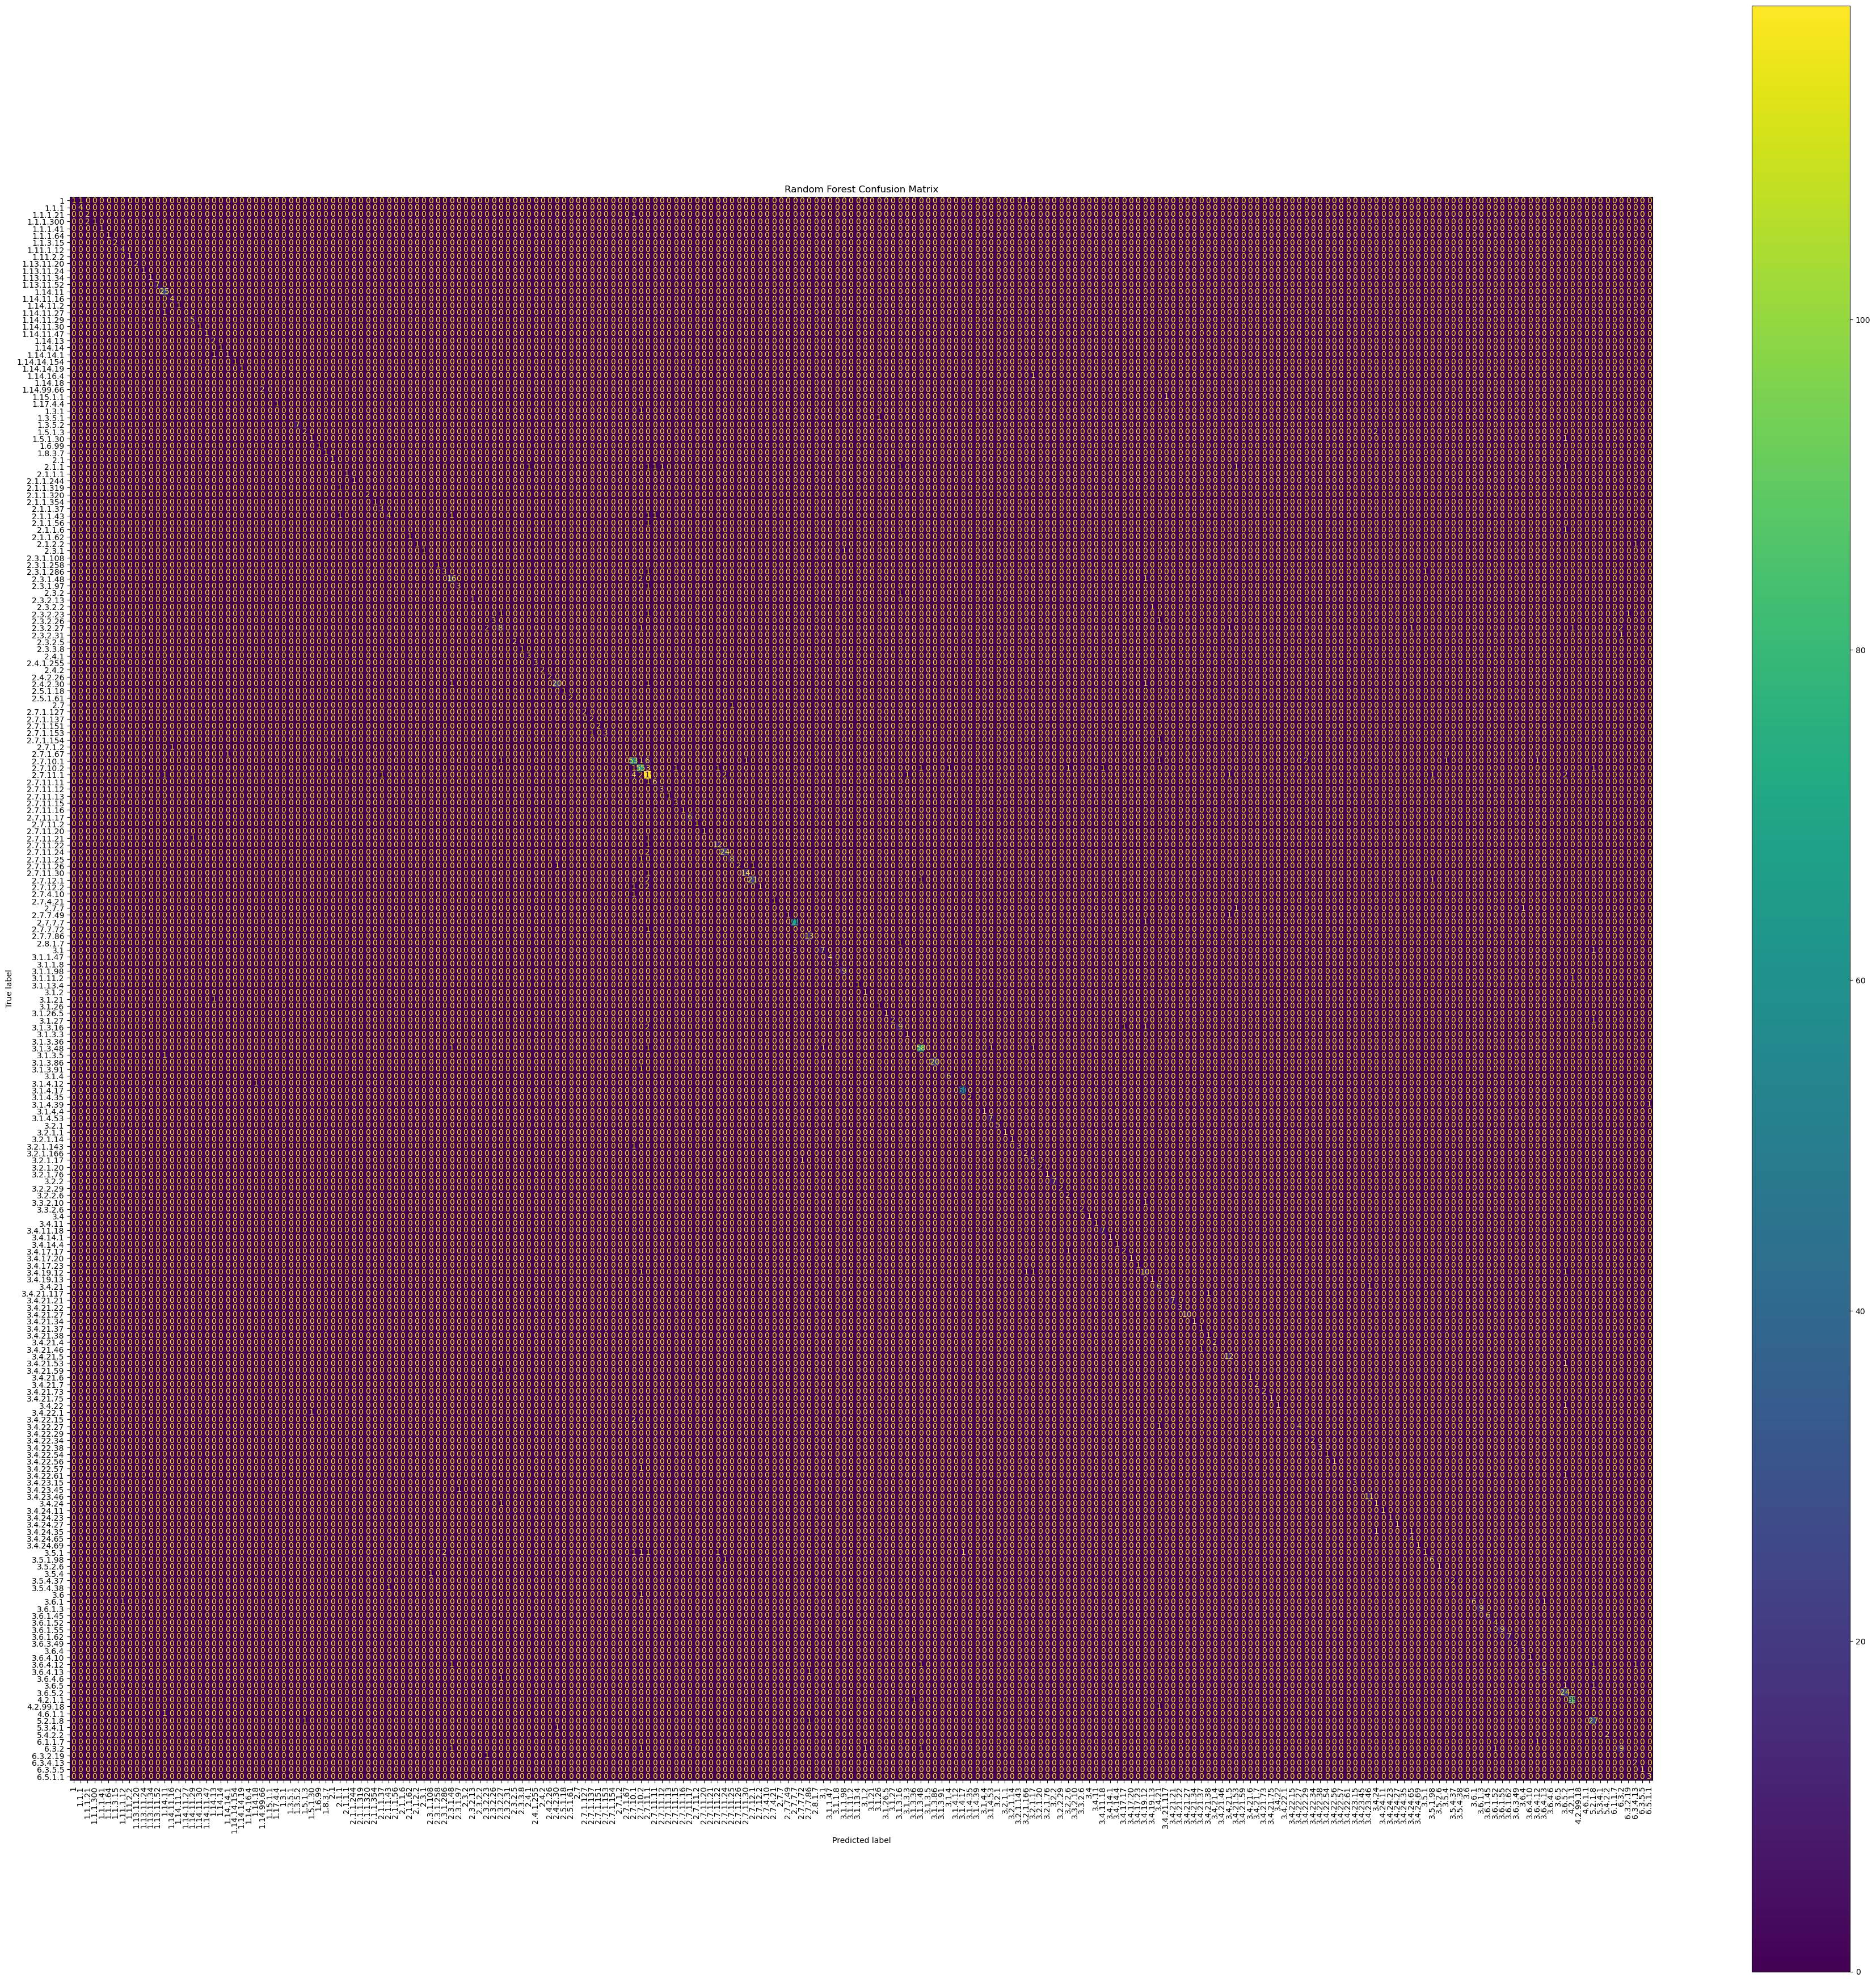


Classification Report for Random Forest:



precision  recall  f1-score   support
1                 1.000   0.333     0.500     3.000
1.1.1             0.800   1.000     0.889     4.000
1.1.1.21          0.500   0.667     0.571     3.000
1.1.1.300         1.000   0.333     0.500     3.000
1.1.1.41          1.000   1.000     1.000     1.000
...                 ...     ...       ...       ...
6.3.5.5           1.000   1.000     1.000     1.000
6.5.1.1           0.750   1.000     0.857     3.000
accuracy          0.851   0.851     0.851     0.851
macro avg         0.680   0.695     0.677  1356.000
weighted avg      0.830   0.851     0.834  1356.000

[229 rows x 4 columns]


Training and tuning XGBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits


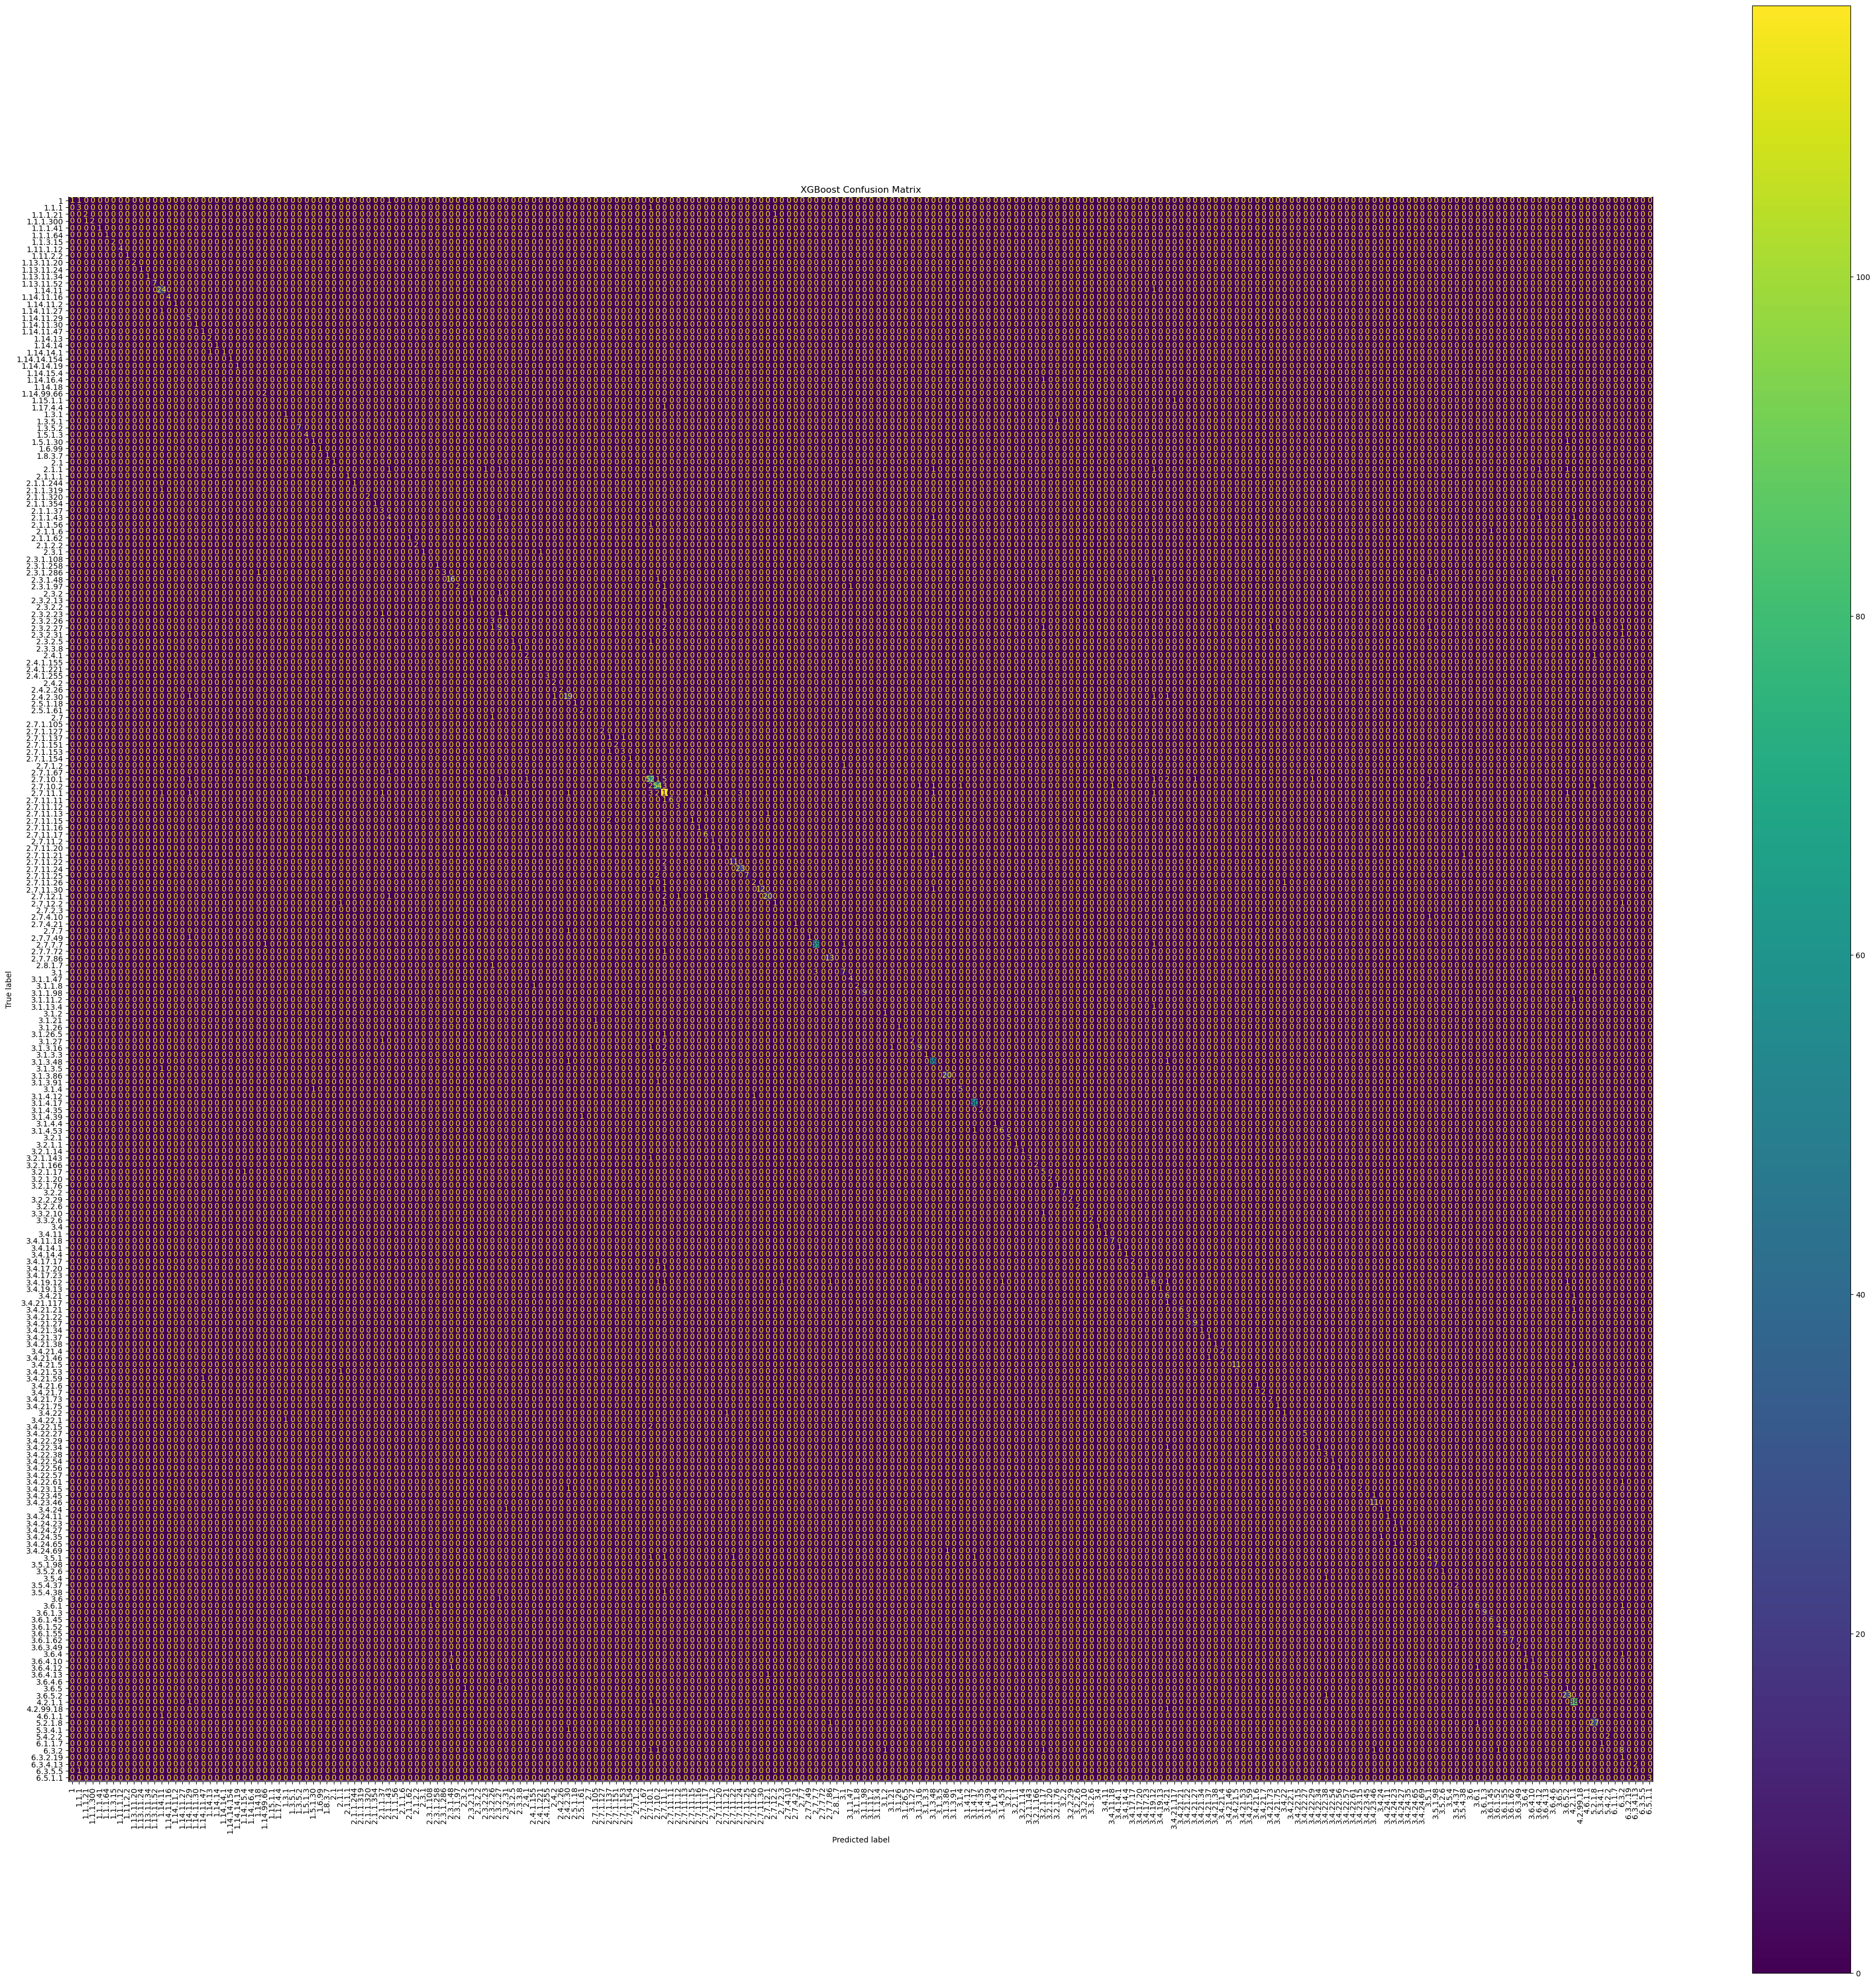


Classification Report for XGBoost:



precision  recall  f1-score   support
1                 1.000   0.333     0.500     3.000
1.1.1             0.600   0.750     0.667     4.000
1.1.1.21          0.667   0.667     0.667     3.000
1.1.1.300         1.000   0.667     0.800     3.000
1.1.1.41          1.000   1.000     1.000     1.000
...                 ...     ...       ...       ...
6.3.5.5           0.000   0.000     0.000     1.000
6.5.1.1           1.000   1.000     1.000     3.000
accuracy          0.826   0.826     0.826     0.826
macro avg         0.637   0.644     0.630  1356.000
weighted avg      0.810   0.826     0.812  1356.000

[233 rows x 4 columns]

In [21]:
# Confusion Matrix and Classification Report
for model_name, mp in model_params_full.items():
    print(f"\nTraining and tuning {model_name}...")
    
    # Set up GridSearchCV
    grid = GridSearchCV(
        estimator=mp['model'],
        param_grid=mp['params'],
        cv=5,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    
    # Fit model on filtered & scaled data
    grid.fit(X_train_scaled_full, y_train_full)
    best_model = grid.best_estimator_
    
    # Save best params and CV score
    tuned_results_full[model_name] = {
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
        'model': best_model
    }
    
    # Predict on filtered test set
    y_pred = best_model.predict(X_test_scaled_full)
    
    # Save top-1 test accuracy
    results_full[model_name] = best_model.score(X_test_scaled_full, y_test_full)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test_full, y_pred)
    labels_used = unique_labels(y_test_full, y_pred)
    class_names = le_full_ec.inverse_transform(labels_used)

    figsize_scale = max(15, len(class_names) // 5)
    fig, ax = plt.subplots(figsize=(figsize_scale, figsize_scale))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=90, ax=ax)
    plt.title(f'{model_name} Confusion Matrix')
    plt.grid(False)
    plt.show()

    # Classification Report
    print(f"\nClassification Report for {model_name}:\n")
    labels_used = unique_labels(y_test_full, y_pred)
    class_names_used = le_full_ec.inverse_transform(labels_used)

    # Generate classification report as dictionary
    report_dict = classification_report(
        y_test_full,
        y_pred,
        labels=labels_used,
        target_names=class_names_used,
        output_dict=True
    )

    report_df = pd.DataFrame(report_dict).transpose()
    display(report_df.round(3))

In [33]:
# Calculate Top-3 Accuracy

top3_results_full = {} 

print("\nCalculating Top-3 Accuracies...")

for model_name, model_info in tuned_results_full.items():
    best_model = model_info['model']
    
    if hasattr(best_model, "predict_proba"):
        # Predict class probabilities
        y_proba = best_model.predict_proba(X_test_scaled_full)
        
        # Get top-3 class indices
        top3_preds_indices = np.argsort(y_proba, axis=1)[:, -3:]
        top3_preds_labels = np.array([le_full_ec.inverse_transform(top3) for top3 in top3_preds_indices])

        # Calculate Top-3 accuracy
        correct_top3 = 0
        for i in range(len(y_test_full)):
            true_label_decoded = le_full_ec.inverse_transform([y_test_full[i]])[0]
            top3_pred_decoded = top3_preds_labels[i][::-1]  # highest prob first
            if true_label_decoded in top3_pred_decoded:
                correct_top3 += 1

        top3_accuracy = correct_top3 / len(y_test_full)
        top3_results_full[model_name] = top3_accuracy

        print(f"Top-3 Accuracy for {model_name}: {top3_accuracy:.4f}")
    
    else:
        top3_results_full[model_name] = None
        print(f"Top-3 Accuracy not available for {model_name} (no predict_proba)")


Calculating Top-3 Accuracies...
Top-3 Accuracy for Logistic Regression: 0.7198
Top-3 Accuracy for SVM: 0.7537
Top-3 Accuracy for Random Forest: 0.8997
Top-3 Accuracy for XGBoost: 0.8864


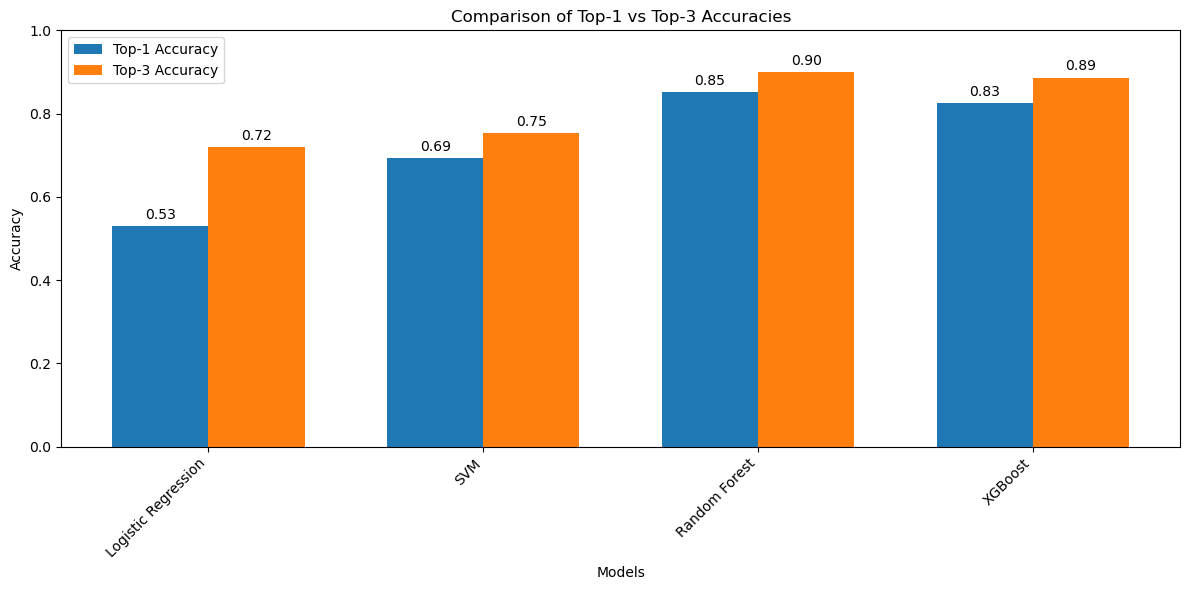

In [34]:
# Plot Top-1 vs Top-3 Accuracies

model_names = list(results_full.keys())
top1_accuracies = [results_full[m] for m in model_names]
top3_accuracies = [top3_results_full[m] if top3_results_full[m] is not None else 0 for m in model_names]

# Bar width
bar_width = 0.35
x = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - bar_width/2, top1_accuracies, width=bar_width, label='Top-1 Accuracy')
bars2 = ax.bar(x + bar_width/2, top3_accuracies, width=bar_width, label='Top-3 Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Top-1 vs Top-3 Accuracies')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_ylim(0, 1)
ax.legend()

# Annotate bars with accuracy values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

# Hyperparameter Tuning

Here, we tune model parameters to improve performance.

We'll explore:

- Different learning rates, optimizers, and architectures (for neural nets)
- Tree depth, number of estimators, and splitting criteria (for tree-based models)
- Cross-validation to validate model generalization

## For EC Class

In [35]:
# Hyperparameter tuning with 10-fold CV for all models
print("\nPerforming hyperparameter tuning with 10-fold CV for all models...")
for name, model_info in model_params.items():
    print(f"\nTuning {name}...")
    model = model_info['model']
    params = model_info['params']
    
    # Using 10-fold CV as requested
    grid_search = GridSearchCV(
        model, 
        params, 
        cv=10,  # 10-fold cross-validation
        scoring='accuracy', 
        n_jobs=-1,
        verbose=1  # Show progress
    )
    grid_search.fit(X_train_scaled, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred_tuned = best_model.predict(X_test_scaled)
    
    accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
    f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')
    
    print(f"{name} (Tuned) - Accuracy: {accuracy_tuned:.4f}, F1 Score: {f1_tuned:.4f}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(classification_report(y_test, y_pred_tuned, target_names=le_class.classes_))
    
    tuned_results[name] = {
        'accuracy': accuracy_tuned,
        'f1_score': f1_tuned,
        'model': best_model,
        'best_params': grid_search.best_params_
    }


Performing hyperparameter tuning with 10-fold CV for all models...

Tuning Logistic Regression...
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

Logistic Regression (Tuned) - Accuracy: 0.5683, F1 Score: 0.5213
Best parameters: {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}
              precision    recall  f1-score   support

           1       0.60      0.03      0.05       106
           2       0.56      0.82      0.67       625
           3       0.51      0.33      0.40       493
           4       0.77      0.91      0.83        94
           5       0.58      0.45      0.51        33
           6       0.00      0.00      0.00        25

    accuracy                           0.57      1376
   macro avg       0.50      0.43      0.41      1376
weighted avg       0.55      0.57      0.52      1376


Tuning SVM...
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVM (Tuned) - Accuracy: 0.7878, F1 Score: 0.7809
Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           1       0.75      0.49      0.59       106
           2       0.76      0

## For EC Number Full

In [36]:
# Hyperparameter tuning with 10-fold CV for all models
print("\nPerforming hyperparameter tuning with 10-fold CV for full EC Number...")
for name, model_info in model_params_full.items():
    print(f"\nTuning {name}...")
    model = model_info['model']
    params = model_info['params']
    
    # Using 10-fold CV
    grid_search_full = GridSearchCV(
        model, 
        params, 
        cv=10,  # 10-fold cross-validation
        scoring='accuracy', 
        n_jobs=-1,
        verbose=1
    )
    
    grid_search_full.fit(X_train_scaled_full, y_train_full)
    
    best_model_full = grid_search_full.best_estimator_
    y_pred_tuned_full = best_model_full.predict(X_test_scaled_full)
    
    accuracy_tuned_full = accuracy_score(y_test_full, y_pred_tuned_full)
    f1_tuned_full = f1_score(y_test_full, y_pred_tuned_full, average='weighted')
    
    print(f"{name} (Tuned) - Accuracy: {accuracy_tuned_full:.4f}, F1 Score: {f1_tuned_full:.4f}")
    print(f"Best parameters: {grid_search_full.best_params_}")
    
    tuned_results_full[name] = {
        'accuracy': accuracy_tuned_full,
        'f1_score': f1_tuned_full,
        'model': best_model_full,
        'best_params': grid_search_full.best_params_
    }


Performing hyperparameter tuning with 10-fold CV for full EC Number...

Tuning Logistic Regression...
Fitting 10 folds for each of 20 candidates, totalling 200 fits


/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/lustre/fs0/bsc4892/share/conda/envs/aibio/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

Logistic Regression (Tuned) - Accuracy: 0.5302, F1 Score: 0.4868
Best parameters: {'C': 100, 'max_iter': 1000, 'solver': 'lbfgs'}

Tuning SVM...
Fitting 10 folds for each of 24 candidates, totalling 240 fits
SVM (Tuned) - Accuracy: 0.6925, F1 Score: 0.6715
Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

Tuning Random Forest...
Fitting 10 folds for each of 36 candidates, totalling 360 fits
Random Forest (Tuned) - Accuracy: 0.8510, F1 Score: 0.8339
Best parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}

Tuning XGBoost...
Fitting 10 folds for each of 27 candidates, totalling 270 fits
XGBoost (Tuned) - Accuracy: 0.8260, F1 Score: 0.8119
Best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}



# Results

This section presents the model's performance on the test data.

We evaluate using:

- Accuracy
- Confusion Matrix
- Classification Report

Visualizations and metric comparisons will also be included to interpret the results better.


## For EC Class

In [42]:
# Compare base models vs tuned models
plt.figure(figsize=(14, 8))
model_names = list(results.keys())
base_accuracies = [results[name]['accuracy'] for name in model_names]
tuned_accuracies = [tuned_results[name]['accuracy'] for name in model_names]
base_f1 = [results[name]['f1_score']for name in model_names]
tuned_f1 = [tuned_results[name]['f1_score'] for name in model_names]

x = np.arange(len(model_names))
width = 0.2

# Plot accuracies
plt.subplot(1, 2, 1)
plt.bar(x - width/2, base_accuracies, width, label='Base Model', color='skyblue')
plt.bar(x + width/2, tuned_accuracies, width, label='Tuned Model', color='darkblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.xticks(x, model_names, rotation=45)
plt.legend()

# Plot F1 scores
plt.subplot(1, 2, 2)
plt.bar(x - width/2, base_f1, width, label='Base Model', color='lightgreen')
plt.bar(x + width/2, tuned_f1, width, label='Tuned Model', color='darkgreen')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison')
plt.xticks(x, model_names, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Identify best model overall
best_model_name = max(tuned_results, key=lambda x: tuned_results[x]['accuracy'])
print(f"\nBest model overall: {best_model_name} with accuracy: {tuned_results[best_model_name]['accuracy']:.4f}")
print(f"Best parameters: {tuned_results[best_model_name]['best_params']}")

# Improvement comparison
print("\nAccuracy improvements after tuning:")
for name in model_names:
    improvement = tuned_results[name]['accuracy'] - results[name]['accuracy']
    print(f"{name}: {improvement:.4f} ({improvement*100:.2f}%)")

TypeError: 'float' object is not subscriptable

<Figure size 1400x800 with 0 Axes>

## For EC Number Full

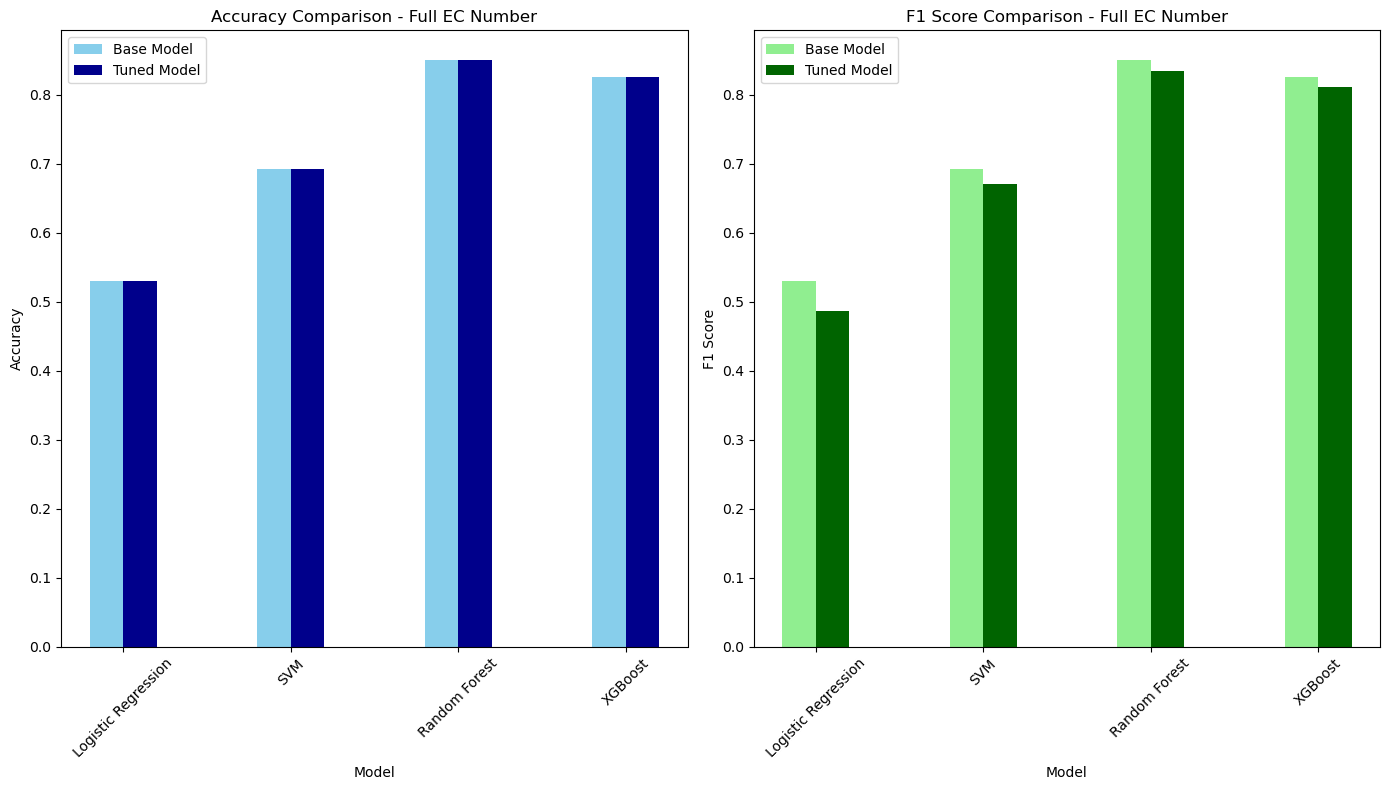


Best model for full EC Number: Random Forest with accuracy: 0.8510
Best parameters: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}

Accuracy improvements after tuning for full EC Number:
Logistic Regression: 0.0000 (0.00%)
SVM: 0.0000 (0.00%)
Random Forest: 0.0000 (0.00%)
XGBoost: 0.0000 (0.00%)


In [40]:
# Compare base models vs tuned models for Full EC Number
plt.figure(figsize=(14, 8))
model_names_full = list(results_full.keys())
base_accuracies_full = [results_full[name] for name in model_names_full]
tuned_accuracies_full = [tuned_results_full[name]['accuracy'] for name in model_names_full]
base_f1_full = [results_full[name] for name in model_names_full]
tuned_f1_full = [tuned_results_full[name]['f1_score'] for name in model_names_full]

x_full = np.arange(len(model_names_full))
width = 0.2

# Plot accuracies
plt.subplot(1, 2, 1)
plt.bar(x_full - width/2, base_accuracies_full, width, label='Base Model', color='skyblue')
plt.bar(x_full + width/2, tuned_accuracies_full, width, label='Tuned Model', color='darkblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison - Full EC Number')
plt.xticks(x_full, model_names_full, rotation=45)
plt.legend()

# Plot F1 scores
plt.subplot(1, 2, 2)
plt.bar(x_full - width/2, base_f1_full, width, label='Base Model', color='lightgreen')
plt.bar(x_full + width/2, tuned_f1_full, width, label='Tuned Model', color='darkgreen')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison - Full EC Number')
plt.xticks(x_full, model_names_full, rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Identify best model overall for Full EC Number
best_model_name_full = max(tuned_results_full, key=lambda x: tuned_results_full[x]['accuracy'])
print(f"\nBest model for full EC Number: {best_model_name_full} with accuracy: {tuned_results_full[best_model_name_full]['accuracy']:.4f}")
print(f"Best parameters: {tuned_results_full[best_model_name_full]['best_params']}")

# Improvement comparison for Full EC Number
print("\nAccuracy improvements after tuning for full EC Number:")
for name in model_names_full:
    improvement_full = tuned_results_full[name]['accuracy'] - results_full[name]['accuracy']
    print(f"{name}: {improvement_full:.4f} ({improvement_full*100:.2f}%)")

# Discussion
## What Worked

- Effective feature selection significantly improved prediction accuracy.
- Certain models (e.g., Random Forest or Neural Network) may generalize well.

## What Didn’t

- Some enzyme classes were underrepresented, which may have affected performance.
- Class imbalance may have skewed accuracy in favor of dominant classes.

## Future Work

- Try deep learning models or transformer-based sequence models.
- Perform feature engineering on sequence data (e.g., embeddings, k-mers).
- Use data augmentation to balance classes.

